# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**EV Charging Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

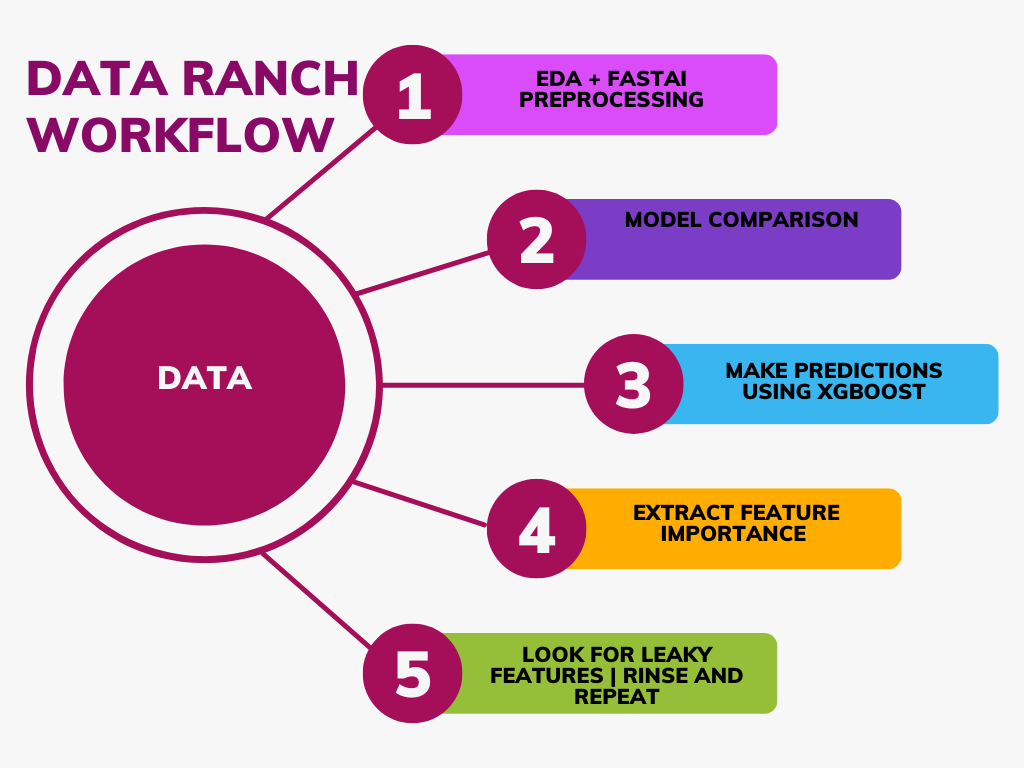

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 571.7 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'electric-vehicle-charging-dataset'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 2000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/electric-vehicle-charging-dataset
CSV!


In [12]:
df

sessionId  kwhTotal  dollars              created                ended  \
0       1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1       3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2       4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3       3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4       3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   
...         ...       ...      ...                  ...                  ...   
1995    3314457      5.89     0.00  0015-07-07 11:00:35  0015-07-07 13:29:06   
1996    9576382      5.89     0.00  0015-07-08 10:36:53  0015-07-08 12:43:05   
1997    2381628      6.99     0.00  0015-07-09 10:35:41  0015-07-09 13:17:06   
1998    2449256      5.57     0.00  0015-07-10 10:33:15  0015-07-10 12:54:06   
1999    9403981      5.74     0.00  0015-07-13 10:33:17  0015-07-13 12:36:05   

      startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
0            15       17           1.51     Tue  android  ...               0   
1            17       19           2.18     Wed  android  ...               0   
2            12       16           4.67     Fri  android  ...               0   
3            19       21           1.77     Wed  android  ...               0   
4            20       21           0.30     Thu  android  ...               0   
...         ...      ...            ...     ...      ...  ...             ...   
1995         11       13           2.48     Tue      ios  ...               1   
1996         10       12           2.10     Wed      ios  ...               1   
1997         10       13           2.69     Thu      ios  ...               1   
1998         10       12           2.35     Fri      ios  ...               1   
1999         10       12           2.05     Mon      ios  ...               1   

      facilityType  Mon  Tues  Wed  Thurs  Fri  Sat  Sun  reportedZip  
0                3    0     1    0      0    0    0    0            0  
1                3    0     0    1      0    0    0    0            0  
2                3    0     0    0      0    1    0    0            0  
3                3    0     0    1      0    0    0    0            0  
4                3    0     0    0      1    0    0    0            0  
...            ...  ...   ...  ...    ...  ...  ...  ...          ...  
1995             3    0     1    0      0    0    0    0            1  
1996             3    0     0    1      0    0    0    0            1  
1997             3    0     0    0      1    0    0    0            1  
1998             3    0     0    0      0    1    0    0            1  
1999             3    1     0    0      0    0    0    0            1  

[2000 rows x 24 columns]

In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

sessionId  kwhTotal  dollars              created                ended  \
0       1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1       3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2       4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3       3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4       3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   
...         ...       ...      ...                  ...                  ...   
1995    3314457      5.89     0.00  0015-07-07 11:00:35  0015-07-07 13:29:06   
1996    9576382      5.89     0.00  0015-07-08 10:36:53  0015-07-08 12:43:05   
1997    2381628      6.99     0.00  0015-07-09 10:35:41  0015-07-09 13:17:06   
1998    2449256      5.57     0.00  0015-07-10 10:33:15  0015-07-10 12:54:06   
1999    9403981      5.74     0.00  0015-07-13 10:33:17  0015-07-13 12:36:05   

      startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
0            15       17           1.51     Tue  android  ...               0   
1            17       19           2.18     Wed  android  ...               0   
2            12       16           4.67     Fri  android  ...               0   
3            19       21           1.77     Wed  android  ...               0   
4            20       21           0.30     Thu  android  ...               0   
...         ...      ...            ...     ...      ...  ...             ...   
1995         11       13           2.48     Tue      ios  ...               1   
1996         10       12           2.10     Wed      ios  ...               1   
1997         10       13           2.69     Thu      ios  ...               1   
1998         10       12           2.35     Fri      ios  ...               1   
1999         10       12           2.05     Mon      ios  ...               1   

      facilityType  Mon  Tues  Wed  Thurs  Fri  Sat  Sun  reportedZip  
0                3    0     1    0      0    0    0    0            0  
1                3    0     0    1      0    0    0    0            0  
2                3    0     0    0      0    1    0    0            0  
3                3    0     0    1      0    0    0    0            0  
4                3    0     0    0      1    0    0    0            0  
...            ...  ...   ...  ...    ...  ...  ...  ...          ...  
1995             3    0     1    0      0    0    0    0            1  
1996             3    0     0    1      0    0    0    0            1  
1997             3    0     0    0      1    0    0    0            1  
1998             3    0     0    0      0    1    0    0            1  
1999             3    1     0    0      0    0    0    0            1  

[2000 rows x 24 columns]

In [15]:
df.isna().sum()

sessionId           0
kwhTotal            0
dollars             0
created             0
ended               0
startTime           0
endTime             0
chargeTimeHrs       0
weekday             0
platform            0
distance          783
userId              0
stationId           0
locationId          0
managerVehicle      0
facilityType        0
Mon                 0
Tues                0
Wed                 0
Thurs               0
Fri                 0
Sat                 0
Sun                 0
reportedZip         0
dtype: int64

In [16]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

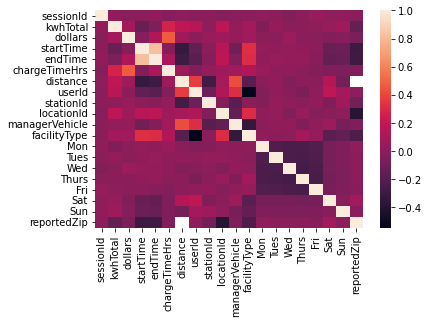

In [17]:
sns.heatmap(df.corr())

In [18]:
df.head().style.background_gradient(cmap = "inferno")

In [19]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [20]:
df.columns

Index(['sessionId', 'kwhTotal', 'dollars', 'created', 'ended', 'startTime',
       'endTime', 'chargeTimeHrs', 'weekday', 'platform', 'distance', 'userId',
       'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon',
       'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip'],
      dtype='object')

In [21]:
# Remove features we don't want to train or predict on
del(df['sessionId'])
del(df['created'])
del(df['ended'])
del(df['startTime'])
del(df['endTime'])
del(df['userId'])

Target Variable: reportedZip
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:02, 15.05it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9852637580012341, 'Adjusted R-Squared': 0.9846079566557393, 'RMSE': 0.05780441827151005, 'Time taken': 0.15087032318115234}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9852256126133576, 'Adjusted R-Squared': 0.9845681136982453, 'RMSE': 0.057879184513951125, 'Time taken': 0.03905534744262695}
{'Model': 'BayesianRidge', 'R-Squared': 0.752924775809227, 'Adjusted R-Squared': 0.7419292815389571, 'RMSE': 0.23669128176826998, 'Time taken': 0.0482025146484375}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05148792266845703}
{'Model': 'DummyRegressor', 'R-Squared': -0.004658342291683937, 'Adjusted R-Squared': -0.04936826851932419, 'RMSE': 0.47728398255126897, 'Time taken': 0.040918827056884766}


 19%|█▉        | 8/42 [00:00<00:01, 20.92it/s]

{'Model': 'ElasticNet', 'R-Squared': -0.0046583594309561605, 'Adjusted R-Squared': -0.04936828642133895, 'RMSE': 0.477284, 'Time taken': 0.03197216987609863}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -272.0033264160156 but the user-supplied value was -272.00347900390625.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9669230133134872, 'Adjusted R-Squared': 0.965451000816967, 'RMSE': 0.08660254037844387, 'Time taken': 0.044302940368652344}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9919821384271893, 'Adjusted R-Squared': 0.9916253225980328, 'RMSE': 0.04263801121065569, 'Time taken': 0.2191333770751953}
{'Model': 'GammaRegressor', 'R-Squared': 0.5991401452773282, 'Adjusted R-Squared': 0.5813008323708219, 'RMSE': 0.301483775159251, 'Time taken': 0.023212671279907227}


 26%|██▌       | 11/42 [00:01<00:03,  7.95it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.40978066428105764, 'Adjusted R-Squared': 0.3835143587647697, 'RMSE': 0.36582584039870925, 'Time taken': 0.487717866897583}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9761633226698225, 'Adjusted R-Squared': 0.9751025281289507, 'RMSE': 0.07351746462837545, 'Time taken': 0.2635343074798584}


 36%|███▌      | 15/42 [00:01<00:03,  6.92it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9827669550152398, 'Adjusted R-Squared': 0.9820000394007348, 'RMSE': 0.06250988116900577, 'Time taken': 0.38520050048828125}
{'Model': 'HuberRegressor', 'R-Squared': 0.742976929588413, 'Adjusted R-Squared': 0.7315387301198346, 'RMSE': 0.24140914403070415, 'Time taken': 0.05441784858703613}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9303178147137462, 'Adjusted R-Squared': 0.9272167750544102, 'RMSE': 0.12569805089976535, 'Time taken': 0.04433608055114746}


 45%|████▌     | 19/42 [00:02<00:02,  8.96it/s]

{'Model': 'KernelRidge', 'R-Squared': -10.866910293513069, 'Adjusted R-Squared': -11.395018866784591, 'RMSE': 1.6403499, 'Time taken': 0.16634702682495117}
{'Model': 'Lars', 'R-Squared': 0.7529635953343351, 'Adjusted R-Squared': 0.7419698286345542, 'RMSE': 0.2366727, 'Time taken': 0.05974888801574707}
{'Model': 'LarsCV', 'R-Squared': 0.7478082175939816, 'Adjusted R-Squared': 0.7365850230890019, 'RMSE': 0.23912948, 'Time taken': 0.07941269874572754}
{'Model': 'Lasso', 'R-Squared': -0.0046583594309561605, 'Adjusted R-Squared': -0.04936828642133895, 'RMSE': 0.477284, 'Time taken': 0.02405095100402832}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -272.0033264160156 but the user-supplied value was -272.00347900390625.


 57%|█████▋    | 24/42 [00:02<00:01, 13.27it/s]

{'Model': 'LassoLars', 'R-Squared': -0.0046583594309561605, 'Adjusted R-Squared': -0.04936828642133895, 'RMSE': 0.477284, 'Time taken': 0.02956867218017578}
{'Model': 'LassoLarsCV', 'R-Squared': 0.7478082175939816, 'Adjusted R-Squared': 0.7365850230890019, 'RMSE': 0.23912948, 'Time taken': 0.06659603118896484}
{'Model': 'LassoLarsIC', 'R-Squared': 0.750632751946281, 'Adjusted R-Squared': 0.7395352566140474, 'RMSE': 0.23778659, 'Time taken': 0.04570508003234863}
{'Model': 'LinearRegression', 'R-Squared': 0.7528605454189334, 'Adjusted R-Squared': 0.741862192728153, 'RMSE': 0.23672204, 'Time taken': 0.0531766414642334}
{'Model': 'LinearSVR', 'R-Squared': 0.7188990455361948, 'Adjusted R-Squared': 0.7063893171961826, 'RMSE': 0.25246363014046685, 'Time taken': 0.16724658012390137}


 62%|██████▏   | 26/42 [00:04<00:04,  3.64it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9322040582986488, 'Adjusted R-Squared': 0.9291869614166516, 'RMSE': 0.123985104, 'Time taken': 1.4178667068481445}


 74%|███████▍  | 31/42 [00:05<00:02,  4.60it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9493141235317545, 'Adjusted R-Squared': 0.9470584693433771, 'RMSE': 0.10720403771522197, 'Time taken': 0.877713680267334}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.4547021743133516, 'Adjusted R-Squared': 0.43043499358907666, 'RMSE': 0.35162888655944774, 'Time taken': 0.020422935485839844}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7465404373262078, 'Adjusted R-Squared': 0.7352608232805156, 'RMSE': 0.23972978895835131, 'Time taken': 0.046102285385131836}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.6752602777989147, 'Adjusted R-Squared': 0.6608085100569816, 'RMSE': 0.27135346392819887, 'Time taken': 0.03202223777770996}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6497986404464456, 'Adjusted R-Squared': 0.6342137631888267, 'RMSE': 0.2817906483903808, 'Time taken': 0.03581690788269043}


 76%|███████▌  | 32/42 [00:42<00:58,  5.84s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.5325670513292959, 'Adjusted R-Squared': -0.6007702970690811, 'RMSE': 0.5894913064200752, 'Time taken': 37.10880708694458}


 79%|███████▊  | 33/42 [00:42<00:43,  4.85s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.4465666331676612, 'Adjusted R-Squared': -0.510942635167269, 'RMSE': 0.5727128, 'Time taken': 0.27665138244628906}


 83%|████████▎ | 35/42 [00:42<00:22,  3.26s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9864395380247526, 'Adjusted R-Squared': 0.9858360619682626, 'RMSE': 0.05545042831214201, 'Time taken': 0.3149871826171875}
{'Model': 'Ridge', 'R-Squared': 0.7529591820938911, 'Adjusted R-Squared': 0.7419652189933574, 'RMSE': 0.2366748, 'Time taken': 0.015128374099731445}
{'Model': 'RidgeCV', 'R-Squared': 0.7528991550963008, 'Adjusted R-Squared': 0.7419025206372356, 'RMSE': 0.23670355341995428, 'Time taken': 0.03295612335205078}
{'Model': 'SGDRegressor', 'R-Squared': 0.7536240787152123, 'Adjusted R-Squared': 0.7426597052548946, 'RMSE': 0.23635608793051552, 'Time taken': 0.025801897048950195}


 90%|█████████ | 38/42 [00:43<00:07,  1.92s/it]

{'Model': 'SVR', 'R-Squared': 0.9358727296630469, 'Adjusted R-Squared': 0.9330188982606171, 'RMSE': 0.12058382044646167, 'Time taken': 0.13907527923583984}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.7528605454189334, 'Adjusted R-Squared': 0.741862192728153, 'RMSE': 0.23672204, 'Time taken': 0.019370555877685547}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6079502492387672, 'Adjusted R-Squared': 0.5905030090216443, 'RMSE': 0.2981523615102978, 'Time taken': 0.046701908111572266}


100%|██████████| 42/42 [00:43<00:00,  1.04s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9950193567061287, 'Adjusted R-Squared': 0.9947977050412182, 'RMSE': 0.0336055, 'Time taken': 0.5217440128326416}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9833159807960586, 'Adjusted R-Squared': 0.9825734982660403, 'RMSE': 0.061506073516147015, 'Time taken': 0.1796398162841797}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: reportedZip
reportedZip
Target Standard Deviation: 0.48538644398046393
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
DecisionTreeRegressor                        1.00       1.00  0.00        0.05
XGBRegressor                                 0.99       1.00  0.03        0.52
ExtraTreesRegressor                          0.99       0.99  0.04        0.22
RandomForestRegressor                        0.99       0.99  0.06        0.31
AdaBoostRegressor                            0.98 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.8120975494384766.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       2       2.00
4       1       1.00
XGBoost RMSE:  0.0336055


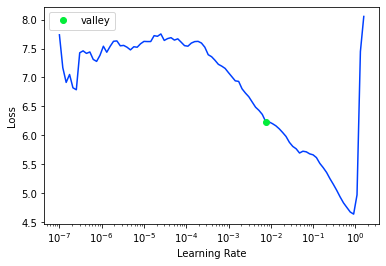

<Figure size 720x720 with 0 Axes>

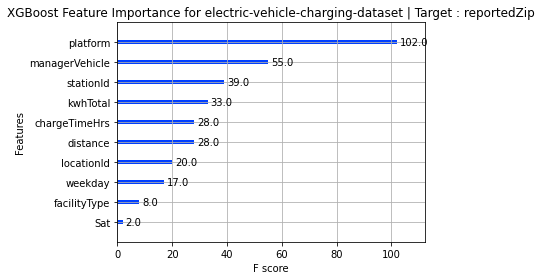

Target Variable: Sun
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:00, 39.12it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.40474440649495413, 'Adjusted R-Squared': 0.3782539743232637, 'RMSE': 0.10801393258602753, 'Time taken': 0.019268274307250977}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6875, 'Adjusted R-Squared': 0.6735929319371727, 'RMSE': 0.07826237921249264, 'Time taken': 0.03870987892150879}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.9474721168407787e-10, 'Time taken': 0.02053999900817871}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8724489795918366, 'Adjusted R-Squared': 0.8667726252804786, 'RMSE': 0.05, 'Time taken': 0.023363113403320312}
{'Model': 'DummyRegressor', 'R-Squared': -0.005759725765306589, 'Adjusted R-Squared': -0.050518666440726, 'RMSE': 0.14040260191677364, 'Time taken': 0.021157026290893555}
{'Model': 'ElasticNet', 'R-Squared': -0.005759778802582494, 'Adjusted R-Squared': -0.05051872183829942, 'RMSE': 0.14040262, 'Time taken': 0.023206472396850586}
ElasticNetCV model failed to execute
Gram

 21%|██▏       | 9/42 [00:00<00:01, 20.69it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9202806122448979, 'Adjusted R-Squared': 0.9167328908002991, 'RMSE': 0.03952847075210474, 'Time taken': 0.21796345710754395}
{'Model': 'GammaRegressor', 'R-Squared': 0.046343490078806227, 'Adjusted R-Squared': 0.003903278904302976, 'RMSE': 0.13671747362519318, 'Time taken': 0.024241209030151367}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.9874386786018117, 'Adjusted R-Squared': -3.1648901381207404, 'RMSE': 0.27956000804942666, 'Time taken': 0.49114274978637695}


 29%|██▊       | 12/42 [00:01<00:03,  7.91it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9229590330127867, 'Adjusted R-Squared': 0.9195305083039317, 'RMSE': 0.03885875645140206, 'Time taken': 0.286452054977417}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8754586220028162, 'Adjusted R-Squared': 0.8699162046573918, 'RMSE': 0.0494065887179514, 'Time taken': 0.37238001823425293}


 38%|███▊      | 16/42 [00:02<00:03,  6.67it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.2282838757748119, 'Adjusted R-Squared': 0.19394048804751307, 'RMSE': 0.12298632458453941, 'Time taken': 0.24047636985778809}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7857142857142857, 'Adjusted R-Squared': 0.7761780104712042, 'RMSE': 0.06480740698407861, 'Time taken': 0.04623675346374512}
{'Model': 'KernelRidge', 'R-Squared': -51.026651206673414, 'Adjusted R-Squared': -53.34197338079238, 'RMSE': 1.0098131, 'Time taken': 0.12844634056091309}


 50%|█████     | 21/42 [00:02<00:01, 10.51it/s]

{'Model': 'Lars', 'R-Squared': 0.9999998977081742, 'Adjusted R-Squared': 0.9999998931559202, 'RMSE': 4.477633e-05, 'Time taken': 0.0515596866607666}
{'Model': 'LarsCV', 'R-Squared': 0.9999998977081742, 'Adjusted R-Squared': 0.9999998931559202, 'RMSE': 4.477633e-05, 'Time taken': 0.06264781951904297}
{'Model': 'Lasso', 'R-Squared': -0.005759778802582494, 'Adjusted R-Squared': -0.05051872183829942, 'RMSE': 0.14040262, 'Time taken': 0.03795218467712402}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -294.4912109375 but the user-supplied value was -294.49072265625.
{'Model': 'LassoLars', 'R-Squared': -0.005759778802582494, 'Adjusted R-Squared': -0.05051872183829942, 'RMSE': 0.14040262, 'Time taken': 0.049062490463256836}


 60%|█████▉    | 25/42 [00:02<00:01, 12.87it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9999998977081742, 'Adjusted R-Squared': 0.9999998931559202, 'RMSE': 4.477633e-05, 'Time taken': 0.06212925910949707}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999998977081742, 'Adjusted R-Squared': 0.9999998931559202, 'RMSE': 4.477633e-05, 'Time taken': 0.0491023063659668}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999783692, 'Adjusted R-Squared': 0.9999999999774065, 'RMSE': 6.511245e-07, 'Time taken': 0.04778170585632324}
{'Model': 'LinearSVR', 'R-Squared': 0.999999999581458, 'Adjusted R-Squared': 0.9999999995628318, 'RMSE': 2.864161886727173e-06, 'Time taken': 0.0531308650970459}
{'Model': 'MLPRegressor', 'R-Squared': 0.7623730141114076, 'Adjusted R-Squared': 0.7517979911791928, 'RMSE': 0.0682458, 'Time taken': 0.6871423721313477}


 74%|███████▍  | 31/42 [00:03<00:01,  7.19it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9738993702826453, 'Adjusted R-Squared': 0.9727378239339672, 'RMSE': 0.02261796503799915, 'Time taken': 0.528374433517456}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.018821523538690488, 'Adjusted R-Squared': -0.024843487193880742, 'RMSE': 0.13867623494543566, 'Time taken': 0.019109249114990234}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.05488099147111214, 'Adjusted R-Squared': 0.01282072145804658, 'RMSE': 0.13610412399029723, 'Time taken': 0.0422055721282959}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8618601270204667, 'Adjusted R-Squared': 0.8557125410501734, 'RMSE': 0.05203404184184477, 'Time taken': 0.0268094539642334}
{'Model': 'PoissonRegressor', 'R-Squared': 0.048227312317463356, 'Adjusted R-Squared': 0.0058709361640520985, 'RMSE': 0.13658237323526676, 'Time taken': 0.030458927154541016}


 76%|███████▌  | 32/42 [00:37<00:47,  4.76s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.020408163266793178, 'Adjusted R-Squared': -0.06581899775772371, 'RMSE': 0.14142135623741256, 'Time taken': 33.911582469940186}
{'Model': 'RANSACRegressor', 'R-Squared': -0.020408163265306367, 'Adjusted R-Squared': -0.06581899775617073, 'RMSE': 0.14142135, 'Time taken': 0.07174944877624512}


 88%|████████▊ | 37/42 [00:38<00:10,  2.18s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7922959183673469, 'Adjusted R-Squared': 0.7830525430067314, 'RMSE': 0.06380438856379708, 'Time taken': 0.3058454990386963}
{'Model': 'Ridge', 'R-Squared': 0.9972945287757922, 'Adjusted R-Squared': 0.9971741282239295, 'RMSE': 0.0072819805, 'Time taken': 0.013051033020019531}
{'Model': 'RidgeCV', 'R-Squared': 0.9999700936163746, 'Adjusted R-Squared': 0.9999687627040142, 'RMSE': 0.0007656142103289722, 'Time taken': 0.04015469551086426}
{'Model': 'SGDRegressor', 'R-Squared': 0.3214596007051398, 'Adjusted R-Squared': 0.2912627766527508, 'RMSE': 0.11532298914864833, 'Time taken': 0.05537009239196777}
{'Model': 'SVR', 'R-Squared': 0.7982573553826461, 'Adjusted R-Squared': 0.7892792795750675, 'RMSE': 0.06288207880231168, 'Time taken': 0.0594635009765625}


 95%|█████████▌| 40/42 [00:38<00:02,  1.44s/it]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999783692, 'Adjusted R-Squared': 0.9999999999774065, 'RMSE': 6.511245e-07, 'Time taken': 0.03249096870422363}
{'Model': 'TweedieRegressor', 'R-Squared': 0.047068473557628554, 'Adjusted R-Squared': 0.004660526045795366, 'RMSE': 0.13666549644394696, 'Time taken': 0.048610687255859375}


100%|██████████| 42/42 [00:39<00:00,  1.08it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8724502388440023, 'Adjusted R-Squared': 0.8667739405726621, 'RMSE': 0.04999975, 'Time taken': 0.49514150619506836}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8753650792423854, 'Adjusted R-Squared': 0.8698184989992455, 'RMSE': 0.04942513982629939, 'Time taken': 0.12288641929626465}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: Sun
Sun
Target Standard Deviation: 0.09636964965693297
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BayesianRidge                                1.00       1.00  0.00        0.02
TransformedTargetRegressor                   1.00       1.00  0.00        0.03
LinearRegression                             1.00       1.00  0.00        0.05
LinearSVR                                    1.00       1.00  0.00        0.05
LassoLarsIC                                  1.00       1.00  0.

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.5474903583526611.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.04999975


<Figure size 432x288 with 0 Axes>

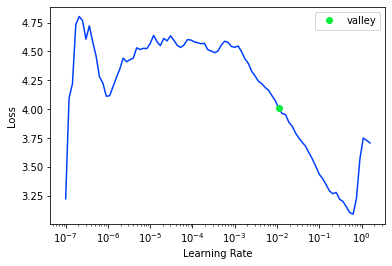

<Figure size 720x720 with 0 Axes>

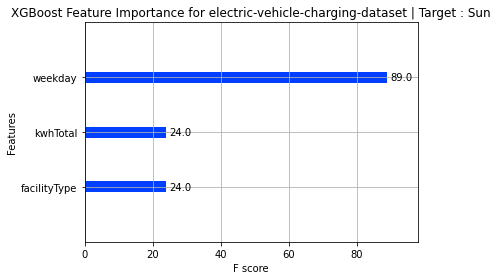

Target Variable: Sat
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:01, 23.92it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9997367955762224, 'Adjusted R-Squared': 0.9997250822903475, 'RMSE': 0.0022713006639456363, 'Time taken': 0.022522687911987305}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8788265306122448, 'Adjusted R-Squared': 0.8734339940164546, 'RMSE': 0.048733971724044825, 'Time taken': 0.04662823677062988}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 7.129147038787462e-11, 'Time taken': 0.05599236488342285}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.4897959183673468, 'Adjusted R-Squared': 0.46709050112191464, 'RMSE': 0.1, 'Time taken': 0.05960512161254883}
{'Model': 'DummyRegressor', 'R-Squared': -0.001992984693877764, 'Adjusted R-Squared': -0.04658429553103982, 'RMSE': 0.14013943948796143, 'Time taken': 0.03728604316711426}


 14%|█▍        | 6/42 [00:00<00:01, 24.39it/s]

{'Model': 'ElasticNet', 'R-Squared': -0.0019930150854041706, 'Adjusted R-Squared': -0.04658432727506856, 'RMSE': 0.14013945, 'Time taken': 0.020929336547851562}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -293.219482421875 but the user-supplied value was -293.2195739746094.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8724489795918366, 'Adjusted R-Squared': 0.8667726252804786, 'RMSE': 0.05, 'Time taken': 0.02431511878967285}


 21%|██▏       | 9/42 [00:00<00:02, 15.45it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9985714285714286, 'Adjusted R-Squared': 0.9985078534031413, 'RMSE': 0.005291502622129186, 'Time taken': 0.22953319549560547}
{'Model': 'GammaRegressor', 'R-Squared': 0.09922186179114811, 'Adjusted R-Squared': 0.05913487658290084, 'RMSE': 0.13287306540037938, 'Time taken': 0.024836301803588867}


 26%|██▌       | 11/42 [00:01<00:03,  8.19it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.9974647538733206, 'Adjusted R-Squared': -2.1308597821870543, 'RMSE': 0.24238463065119675, 'Time taken': 0.48163700103759766}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9958533424987646, 'Adjusted R-Squared': 0.9956688053848353, 'RMSE': 0.009015236382048715, 'Time taken': 0.29683566093444824}


 31%|███       | 13/42 [00:01<00:05,  5.19it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9917940901881143, 'Adjusted R-Squared': 0.991428905720046, 'RMSE': 0.012682106777383687, 'Time taken': 0.40772390365600586}


 38%|███▊      | 16/42 [00:02<00:04,  6.25it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9999999145095118, 'Adjusted R-Squared': 0.9999999107049612, 'RMSE': 4.093425910791802e-05, 'Time taken': 0.22650814056396484}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04106616973876953}
{'Model': 'KernelRidge', 'R-Squared': -52.72849860969856, 'Adjusted R-Squared': -55.119557448350065, 'RMSE': 1.0261962, 'Time taken': 0.12324762344360352}
{'Model': 'Lars', 'R-Squared': 0.999999999918052, 'Adjusted R-Squared': 0.9999999999144051, 'RMSE': 1.2673523e-06, 'Time taken': 0.02597332000732422}


 52%|█████▏    | 22/42 [00:02<00:01, 11.99it/s]

{'Model': 'LarsCV', 'R-Squared': 0.999999999918052, 'Adjusted R-Squared': 0.9999999999144051, 'RMSE': 1.2673523e-06, 'Time taken': 0.06226944923400879}
{'Model': 'Lasso', 'R-Squared': -0.0019930150854041706, 'Adjusted R-Squared': -0.04658432727506856, 'RMSE': 0.14013945, 'Time taken': 0.024427413940429688}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -293.219482421875 but the user-supplied value was -293.2195739746094.
{'Model': 'LassoLars', 'R-Squared': -0.0019930150854041706, 'Adjusted R-Squared': -0.04658432727506856, 'RMSE': 0.14013945, 'Time taken': 0.02280712127685547}
{'Model': 'LassoLarsCV', 'R-Squared': 0.999999998814865, 'Adjusted R-Squared': 0.9999999987621234, 'RMSE': 4.8196107e-06, 'Time taken': 0.07230234146118164}
{'Model': 'LassoLarsIC', 'R-Squared': 0.999999998814865, 'Adjusted R-Squared': 0.9999999987

 57%|█████▋    | 24/42 [00:02<00:01, 13.37it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.9999999999951893, 'Adjusted R-Squared': 0.9999999999949752, 'RMSE': 3.070652e-07, 'Time taken': 0.046387434005737305}
{'Model': 'LinearSVR', 'R-Squared': 0.9999999999994933, 'Adjusted R-Squared': 0.9999999999994708, 'RMSE': 9.965542469136009e-08, 'Time taken': 0.024807214736938477}


 62%|██████▏   | 26/42 [00:03<00:02,  7.06it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8456973986862347, 'Adjusted R-Squared': 0.8388305289942609, 'RMSE': 0.05499392, 'Time taken': 0.608428955078125}


 67%|██████▋   | 28/42 [00:03<00:03,  4.63it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9995365509807316, 'Adjusted R-Squared': 0.9995159262861568, 'RMSE': 0.0030139012554597673, 'Time taken': 0.790614128112793}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.014392792578189706, 'Adjusted R-Squared': -0.0294693082756603, 'RMSE': 0.13898885302594405, 'Time taken': 0.01712775230407715}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.49150632088807, 'Adjusted R-Squared': 0.46887702103230355, 'RMSE': 0.09983223983560534, 'Time taken': 0.03837943077087402}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8193687290727798, 'Adjusted R-Squared': 0.8113301646597884, 'RMSE': 0.05950103284963645, 'Time taken': 0.02476358413696289}
{'Model': 'PoissonRegressor', 'R-Squared': 0.10504057937886169, 'Adjusted R-Squared': 0.06521254233551266, 'RMSE': 0.13244321290339608, 'Time taken': 0.029784202575683594}


 76%|███████▌  | 32/42 [00:38<00:40,  4.02s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.020408163265655643, 'Adjusted R-Squared': -0.06581899775653555, 'RMSE': 0.1414213562373337, 'Time taken': 34.95004463195801}
{'Model': 'RANSACRegressor', 'R-Squared': -0.020408163265306367, 'Adjusted R-Squared': -0.06581899775617073, 'RMSE': 0.14142135, 'Time taken': 0.0355677604675293}


 88%|████████▊ | 37/42 [00:39<00:10,  2.06s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9190816326530612, 'Adjusted R-Squared': 0.9154805534779357, 'RMSE': 0.03982461550347976, 'Time taken': 0.4078688621520996}
{'Model': 'Ridge', 'R-Squared': 0.999706654889156, 'Adjusted R-Squared': 0.9996936002638043, 'RMSE': 0.0023978248, 'Time taken': 0.01881718635559082}
{'Model': 'RidgeCV', 'R-Squared': 0.9999969634570156, 'Adjusted R-Squared': 0.9999968283229037, 'RMSE': 0.0002439595099492872, 'Time taken': 0.042459964752197266}
{'Model': 'SGDRegressor', 'R-Squared': 0.6922245371028055, 'Adjusted R-Squared': 0.6785277233089513, 'RMSE': 0.07766852047506126, 'Time taken': 0.06431984901428223}
{'Model': 'SVR', 'R-Squared': 0.7358467071678394, 'Adjusted R-Squared': 0.7240911941360417, 'RMSE': 0.07195418361367424, 'Time taken': 0.06377243995666504}


 95%|█████████▌| 40/42 [00:39<00:02,  1.40s/it]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999951893, 'Adjusted R-Squared': 0.9999999999949752, 'RMSE': 3.070652e-07, 'Time taken': 0.0221712589263916}
{'Model': 'TweedieRegressor', 'R-Squared': 0.10041901794108388, 'Adjusted R-Squared': 0.060385309315425406, 'RMSE': 0.13278474026918435, 'Time taken': 0.04752397537231445}


100%|██████████| 42/42 [00:40<00:00,  1.04it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9519425968958144, 'Adjusted R-Squared': 0.9498039166529579, 'RMSE': 0.030690797, 'Time taken': 0.5096597671508789}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9921302197856144, 'Adjusted R-Squared': 0.9917799939645554, 'RMSE': 0.012419649439575855, 'Time taken': 0.13172173500061035}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: Sat
Sat
Target Standard Deviation: 0.1598778830858102
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BayesianRidge                                1.00       1.00  0.00        0.06
KNeighborsRegressor                          1.00       1.00  0.00        0.04
LinearSVR                                    1.00       1.00  0.00        0.02
TransformedTargetRegressor                   1.00       1.00  0.00        0.02
LinearRegression                             1.00       1.00  0.

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.4612954258918762.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.01
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.030690804


<Figure size 432x288 with 0 Axes>

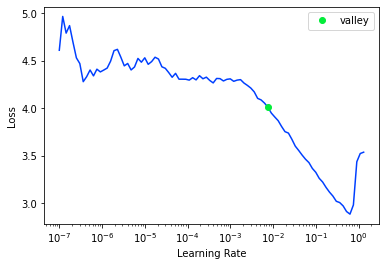

<Figure size 720x720 with 0 Axes>

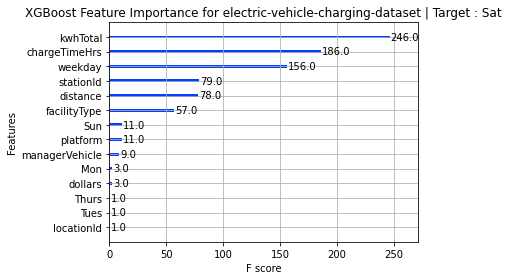

Target Variable: Fri
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:01, 30.25it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014481306076049805}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03262734413146973}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.166824225109877e-11, 'Time taken': 0.032912254333496094}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05161690711975098}
{'Model': 'DummyRegressor', 'R-Squared': -0.003929391504018165, 'Adjusted R-Squared': -0.04860687751335924, 'RMSE': 0.36963294715839384, 'Time taken': 0.0414731502532959}
{'Model': 'ElasticNet', 'R-Squared': -0.003929365652984407, 'Adjusted R-Squared': -0.048606850511886845, 'RMSE': 0.36963293, 'Time taken': 0.025088071823120117}


 19%|█▉        | 8/42 [00:00<00:01, 28.18it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -282.9577941894531 but the user-supplied value was -282.9576110839844.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04433083534240723}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17485904693603516}
{'Model': 'GammaRegressor', 'R-Squared': 0.5791938273648956, 'Adjusted R-Squared': 0.5604668510957941, 'RMSE': 0.23930961129269077, 'Time taken': 0.024762868881225586}


 26%|██▌       | 11/42 [00:00<00:03,  8.81it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.4338105233180145, 'Adjusted R-Squared': 0.4086136094342613, 'RMSE': 0.2775875521203877, 'Time taken': 0.49973511695861816}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992917199, 'Adjusted R-Squared': 0.9999999992601996, 'RMSE': 9.817968151512775e-06, 'Time taken': 0.18699002265930176}


 31%|███       | 13/42 [00:01<00:03,  8.11it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992917199, 'Adjusted R-Squared': 0.9999999992601996, 'RMSE': 9.81796822420974e-06, 'Time taken': 0.10796165466308594}


 36%|███▌      | 15/42 [00:01<00:03,  7.97it/s]

{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.419664649961046e-11, 'Time taken': 0.216141939163208}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9882433983926521, 'Adjusted R-Squared': 0.9877201988446811, 'RMSE': 0.04, 'Time taken': 0.04385089874267578}
{'Model': 'KernelRidge', 'R-Squared': -9.332573955286247, 'Adjusted R-Squared': -9.792400544919403, 'RMSE': 1.1858325, 'Time taken': 0.12325215339660645}


 45%|████▌     | 19/42 [00:01<00:02, 10.21it/s]

{'Model': 'Lars', 'R-Squared': 0.9999999999884057, 'Adjusted R-Squared': 0.9999999999878898, 'RMSE': 1.2561458e-06, 'Time taken': 0.05581855773925781}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999884057, 'Adjusted R-Squared': 0.9999999999878898, 'RMSE': 1.2561458e-06, 'Time taken': 0.0638117790222168}
{'Model': 'Lasso', 'R-Squared': -0.003929365652984407, 'Adjusted R-Squared': -0.048606850511886845, 'RMSE': 0.36963293, 'Time taken': 0.035498619079589844}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -282.9577941894531 but the user-supplied value was -282.9576110839844.
{'Model': 'LassoLars', 'R-Squared': -0.003929365652984407, 'Adjusted R-Squared': -0.048606850511886845, 'RMSE': 0.36963293, 'Time taken': 0.04281187057495117}


 57%|█████▋    | 24/42 [00:02<00:01, 12.46it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999995166142, 'Adjusted R-Squared': 0.9999999994951023, 'RMSE': 8.110844e-06, 'Time taken': 0.06878542900085449}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999995166142, 'Adjusted R-Squared': 0.9999999994951023, 'RMSE': 8.110844e-06, 'Time taken': 0.07633805274963379}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999982998, 'Adjusted R-Squared': 0.9999999999982241, 'RMSE': 4.810191e-07, 'Time taken': 0.07722258567810059}
{'Model': 'LinearSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.045214873725956e-11, 'Time taken': 0.03362154960632324}


 62%|██████▏   | 26/42 [00:02<00:02,  7.21it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9761961092319061, 'Adjusted R-Squared': 0.9751367737788758, 'RMSE': 0.05691714, 'Time taken': 0.5477831363677979}


 71%|███████▏  | 30/42 [00:04<00:03,  3.80it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9983340167427263, 'Adjusted R-Squared': 0.9982598761265649, 'RMSE': 0.015057553218222464, 'Time taken': 1.66831636428833}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5055101091183527, 'Adjusted R-Squared': 0.4835040144979653, 'RMSE': 0.2594166216478316, 'Time taken': 0.01763606071472168}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9718783077106349, 'Adjusted R-Squared': 0.9706268187867626, 'RMSE': 0.06186425914860525, 'Time taken': 0.07473874092102051}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9895305315004205, 'Adjusted R-Squared': 0.9890646127452036, 'RMSE': 0.03774691018632725, 'Time taken': 0.05698990821838379}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6797955981342683, 'Adjusted R-Squared': 0.6655456640198247, 'RMSE': 0.20875300672424918, 'Time taken': 0.04167032241821289}


 76%|███████▌  | 32/42 [00:37<00:49,  4.98s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.19402985064854228, 'Adjusted R-Squared': -0.2471673047349956, 'RMSE': 0.40311288739843093, 'Time taken': 32.83672285079956}


 79%|███████▊  | 33/42 [00:37<00:37,  4.17s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.19402985074626855, 'Adjusted R-Squared': -0.24716730483707106, 'RMSE': 0.4031129, 'Time taken': 0.29990315437316895}


 88%|████████▊ | 37/42 [00:38<00:09,  1.86s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2774543762207031}
{'Model': 'Ridge', 'R-Squared': 0.999998606650173, 'Adjusted R-Squared': 0.9999985446424582, 'RMSE': 0.00043546088, 'Time taken': 0.021038532257080078}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999860716443, 'Adjusted R-Squared': 0.999999985451796, 'RMSE': 4.353805411838673e-05, 'Time taken': 0.048238277435302734}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999981280692838, 'Adjusted R-Squared': 0.9999980447634665, 'RMSE': 0.0005047356445788945, 'Time taken': 0.06311202049255371}


 95%|█████████▌| 40/42 [00:38<00:02,  1.15s/it]

{'Model': 'SVR', 'R-Squared': 0.9531545685788728, 'Adjusted R-Squared': 0.9510698242486132, 'RMSE': 0.07984591681776235, 'Time taken': 0.07622051239013672}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999982998, 'Adjusted R-Squared': 0.9999999999982241, 'RMSE': 4.810191e-07, 'Time taken': 0.018694400787353516}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6052179984745503, 'Adjusted R-Squared': 0.5876491659459309, 'RMSE': 0.23179163707973624, 'Time taken': 0.04685473442077637}


100%|██████████| 42/42 [00:38<00:00,  1.08it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999976265007, 'Adjusted R-Squared': 0.9999999975208738, 'RMSE': 1.7972714e-05, 'Time taken': 0.5163226127624512}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992917199, 'Adjusted R-Squared': 0.9999999992601996, 'RMSE': 9.81796822420974e-06, 'Time taken': 0.057890892028808594}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: Fri
Fri
Target Standard Deviation: 0.38880375432215153
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.03
DecisionTreeRegressor                        1.00       1.00  0.00        0.05
RandomForestRegressor                        1.00       1.00  0.00        0.28
ExtraTreeRegressor                           1.00       1.00

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.911709189414978.
Better model found at epoch 1 with _rmse value: 0.6226636171340942.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.00
2       2       2.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  1.7972714e-05


<Figure size 432x288 with 0 Axes>

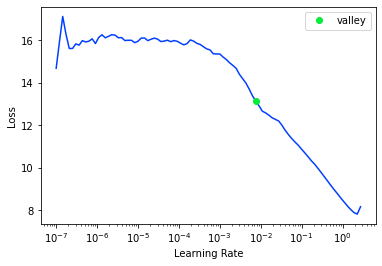

<Figure size 720x720 with 0 Axes>

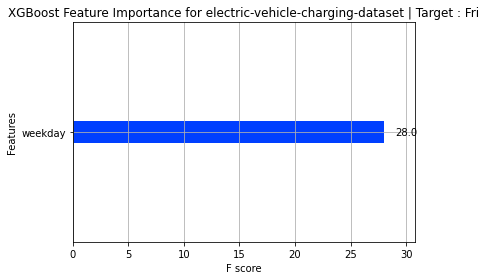

Target Variable: Thurs
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:00, 39.32it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014866113662719727}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03444314002990723}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.3579674877126154e-11, 'Time taken': 0.028212547302246094}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023830413818359375}
{'Model': 'DummyRegressor', 'R-Squared': -0.008861455082385339, 'Adjusted R-Squared': -0.05375843083212484, 'RMSE': 0.4334675773630595, 'Time taken': 0.03858327865600586}
{'Model': 'ElasticNet', 'R-Squared': -0.00886149331864794, 'Adjusted R-Squared': -0.0537584707700014, 'RMSE': 0.4334676, 'Time taken': 0.04850959777832031}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please che

 19%|█▉        | 8/42 [00:00<00:01, 28.90it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04657316207885742}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.19297361373901367}
{'Model': 'GammaRegressor', 'R-Squared': 0.35560207467502847, 'Adjusted R-Squared': 0.32692468009250364, 'RMSE': 0.34643193574603176, 'Time taken': 0.026463031768798828}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.6007887011368527, 'Adjusted R-Squared': 0.5830227532816865, 'RMSE': 0.27267308144120733, 'Time taken': 0.487703800201416}


 29%|██▊       | 12/42 [00:01<00:03,  8.00it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992882402, 'Adjusted R-Squared': 0.999999999256565, 'RMSE': 1.1513505226933767e-05, 'Time taken': 0.21782493591308594}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992882402, 'Adjusted R-Squared': 0.999999999256565, 'RMSE': 1.1513505292795e-05, 'Time taken': 0.12828445434570312}


 38%|███▊      | 16/42 [00:01<00:03,  7.92it/s]

{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.4572024038957163e-11, 'Time taken': 0.2307279109954834}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9897983153797107, 'Adjusted R-Squared': 0.9893443137081271, 'RMSE': 0.04358898943540673, 'Time taken': 0.045391082763671875}
{'Model': 'KernelRidge', 'R-Squared': -6.82185849609293, 'Adjusted R-Squared': -7.169951675238426, 'RMSE': 1.2069682, 'Time taken': 0.1347944736480713}


 52%|█████▏    | 22/42 [00:01<00:01, 13.64it/s]

{'Model': 'Lars', 'R-Squared': 0.9999999998514775, 'Adjusted R-Squared': 0.9999999998448679, 'RMSE': 5.25941e-06, 'Time taken': 0.05289959907531738}
{'Model': 'LarsCV', 'R-Squared': 0.9999999998514775, 'Adjusted R-Squared': 0.9999999998448679, 'RMSE': 5.25941e-06, 'Time taken': 0.05599546432495117}
{'Model': 'Lasso', 'R-Squared': -0.00886149331864794, 'Adjusted R-Squared': -0.0537584707700014, 'RMSE': 0.4334676, 'Time taken': 0.02384805679321289}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -280.0667724609375 but the user-supplied value was -280.0663757324219.
{'Model': 'LassoLars', 'R-Squared': -0.00886149331864794, 'Adjusted R-Squared': -0.0537584707700014, 'RMSE': 0.4334676, 'Time taken': 0.02291250228881836}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999998514775, 'Adjusted R-Squared': 0.9999999998448679, 'RMSE': 

 60%|█████▉    | 25/42 [00:02<00:01, 16.27it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999998514775, 'Adjusted R-Squared': 0.9999999998448679, 'RMSE': 5.25941e-06, 'Time taken': 0.03298640251159668}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999996388, 'Adjusted R-Squared': 0.9999999999996227, 'RMSE': 2.5934872e-07, 'Time taken': 0.022117137908935547}
{'Model': 'LinearSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 8.00656778332972e-12, 'Time taken': 0.047252655029296875}
{'Model': 'MLPRegressor', 'R-Squared': 0.9777990018220466, 'Adjusted R-Squared': 0.9768109992853314, 'RMSE': 0.064302385, 'Time taken': 0.614220142364502}


 67%|██████▋   | 28/42 [00:04<00:04,  3.48it/s]

{'Model': 'NuSVR', 'R-Squared': 0.998090351059094, 'Adjusted R-Squared': 0.9980053666821428, 'RMSE': 0.018858954900467042, 'Time taken': 1.711167812347412}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.07357581308258188, 'Adjusted R-Squared': 0.03234751157055027, 'RMSE': 0.41538020494746847, 'Time taken': 0.017328262329101562}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9622305790144527, 'Adjusted R-Squared': 0.9605497409077661, 'RMSE': 0.08387084475356743, 'Time taken': 0.03992652893066406}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.976474139244032, 'Adjusted R-Squared': 0.9754271768543685, 'RMSE': 0.06619323627961786, 'Time taken': 0.025072336196899414}
{'Model': 'PoissonRegressor', 'R-Squared': 0.44550056573797625, 'Adjusted R-Squared': 0.42082388934411663, 'RMSE': 0.32135969568357164, 'Time taken': 0.029395341873168945}


 76%|███████▌  | 32/42 [00:39<00:34,  3.49s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.32890365427918167, 'Adjusted R-Squared': -0.3880433456999828, 'RMSE': 0.4974937185147752, 'Time taken': 35.41606044769287}


 79%|███████▊  | 33/42 [00:40<00:28,  3.12s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.3289036544850499, 'Adjusted R-Squared': -0.38804334591501277, 'RMSE': 0.4974937, 'Time taken': 0.33445310592651367}


 88%|████████▊ | 37/42 [00:40<00:08,  1.76s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2946031093597412}
{'Model': 'Ridge', 'R-Squared': 0.9999945050400857, 'Adjusted R-Squared': 0.9999942604999847, 'RMSE': 0.0010116333, 'Time taken': 0.02315235137939453}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999447020672, 'Adjusted R-Squared': 0.9999999422411644, 'RMSE': 0.00010148346844917992, 'Time taken': 0.045911550521850586}
{'Model': 'SGDRegressor', 'R-Squared': 0.9998927334639507, 'Adjusted R-Squared': 0.9998879598222941, 'RMSE': 0.004469644496303007, 'Time taken': 0.053920745849609375}


 93%|█████████▎| 39/42 [00:40<00:03,  1.29s/it]

{'Model': 'SVR', 'R-Squared': 0.9656311234422823, 'Adjusted R-Squared': 0.9641016184645829, 'RMSE': 0.08000617759521092, 'Time taken': 0.07613015174865723}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999996388, 'Adjusted R-Squared': 0.9999999999996227, 'RMSE': 2.5934872e-07, 'Time taken': 0.015725135803222656}
{'Model': 'TweedieRegressor', 'R-Squared': 0.37833801634426767, 'Adjusted R-Squared': 0.35067243068419585, 'RMSE': 0.34026557138282787, 'Time taken': 0.027646541595458984}


100%|██████████| 42/42 [00:41<00:00,  1.01it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999804017922, 'Adjusted R-Squared': 0.9999999795296206, 'RMSE': 6.041559e-05, 'Time taken': 0.49014830589294434}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992882402, 'Adjusted R-Squared': 0.999999999256565, 'RMSE': 1.1513505292795e-05, 'Time taken': 0.05412650108337402}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: Thurs
Thurs
Target Standard Deviation: 0.40506509893472675
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.03
DecisionTreeRegressor                        1.00       1.00  0.00        0.02
RandomForestRegressor                        1.00       1.00  0.00        0.29
ExtraTreeRegressor                           1.00       1.0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.7610900402069092.
Better model found at epoch 1 with _rmse value: 0.6849844455718994.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  6.041559e-05


<Figure size 432x288 with 0 Axes>

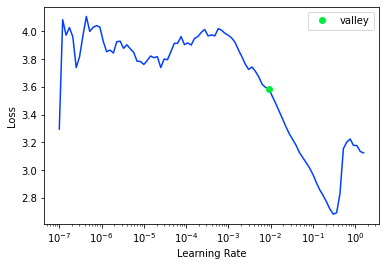

<Figure size 720x720 with 0 Axes>

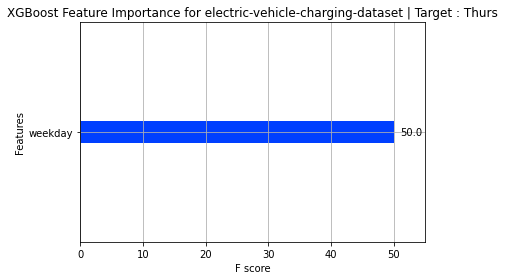

Target Variable: Wed
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:00, 38.47it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014892816543579102}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03236722946166992}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.4740023609932056e-11, 'Time taken': 0.034323930740356445}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.022072553634643555}
{'Model': 'DummyRegressor', 'R-Squared': -0.005736960050818363, 'Adjusted R-Squared': -0.05049488759234677, 'RMSE': 0.42203793150023844, 'Time taken': 0.038216352462768555}
{'Model': 'ElasticNet', 'R-Squared': -0.00573698034534198, 'Adjusted R-Squared': -0.050494908790029935, 'RMSE': 0.4220379, 'Time taken': 0.051990509033203125}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - pleas

 19%|█▉        | 8/42 [00:00<00:01, 32.27it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02742481231689453}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.1923503875732422}
{'Model': 'GammaRegressor', 'R-Squared': 0.5282570066031484, 'Adjusted R-Squared': 0.5072632084676865, 'RMSE': 0.28904270295335677, 'Time taken': 0.02663588523864746}


 29%|██▊       | 12/42 [00:01<00:03,  8.09it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.5704426939062501, 'Adjusted R-Squared': 0.5513262692895127, 'RMSE': 0.2758162411991054, 'Time taken': 0.5353174209594727}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992904446, 'Adjusted R-Squared': 0.9999999992588675, 'RMSE': 1.1209917844147647e-05, 'Time taken': 0.1751232147216797}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992904447, 'Adjusted R-Squared': 0.9999999992588676, 'RMSE': 1.1209917178503348e-05, 'Time taken': 0.10353827476501465}


 38%|███▊      | 16/42 [00:01<00:03,  8.33it/s]

{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.9249110334677872e-10, 'Time taken': 0.24539804458618164}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9887069452286844, 'Adjusted R-Squared': 0.9882043747283903, 'RMSE': 0.04472135954999579, 'Time taken': 0.045635223388671875}
{'Model': 'KernelRidge', 'R-Squared': -7.106352307243174, 'Adjusted R-Squared': -7.467106205733053, 'RMSE': 1.19818, 'Time taken': 0.09591221809387207}
{'Model': 'Lars', 'R-Squared': 0.9999999997770599, 'Adjusted R-Squared': 0.9999999997671385, 'RMSE': 6.283525e-06, 'Time taken': 0.02713489532470703}


 52%|█████▏    | 22/42 [00:01<00:01, 13.22it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9999999997770599, 'Adjusted R-Squared': 0.9999999997671385, 'RMSE': 6.283525e-06, 'Time taken': 0.054001569747924805}
{'Model': 'Lasso', 'R-Squared': -0.00573698034534198, 'Adjusted R-Squared': -0.050494908790029935, 'RMSE': 0.4220379, 'Time taken': 0.024798154830932617}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -283.39251708984375 but the user-supplied value was -283.3919982910156.
{'Model': 'LassoLars', 'R-Squared': -0.00573698034534198, 'Adjusted R-Squared': -0.050494908790029935, 'RMSE': 0.4220379, 'Time taken': 0.04345202445983887}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999997770599, 'Adjusted R-Squared': 0.9999999997671385, 'RMSE': 6.283525e-06, 'Time taken': 0.07198524475097656}


 57%|█████▋    | 24/42 [00:02<00:01, 14.31it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999997770599, 'Adjusted R-Squared': 0.9999999997671385, 'RMSE': 6.283525e-06, 'Time taken': 0.05057811737060547}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999990737, 'Adjusted R-Squared': 0.9999999999990326, 'RMSE': 4.0501564e-07, 'Time taken': 0.045660972595214844}
{'Model': 'LinearSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 5.3397301288582074e-12, 'Time taken': 0.04183769226074219}


 62%|██████▏   | 26/42 [00:02<00:02,  7.31it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9804193592112672, 'Adjusted R-Squared': 0.9795479694379466, 'RMSE': 0.05888745, 'Time taken': 0.6081287860870361}


 67%|██████▋   | 28/42 [00:04<00:04,  3.09it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9990568227114252, 'Adjusted R-Squared': 0.999014848853033, 'RMSE': 0.012924267786091652, 'Time taken': 1.6436142921447754}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.41038788789299496, 'Adjusted R-Squared': 0.3841486054170288, 'RMSE': 0.3231413081828917, 'Time taken': 0.01668715476989746}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9961436566281777, 'Adjusted R-Squared': 0.9959720392529919, 'RMSE': 0.02613347300206635, 'Time taken': 0.03888654708862305}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9951475585319349, 'Adjusted R-Squared': 0.9949316121838797, 'RMSE': 0.029314968599579397, 'Time taken': 0.02439141273498535}
{'Model': 'PoissonRegressor', 'R-Squared': 0.637477858614639, 'Adjusted R-Squared': 0.6213446743121491, 'RMSE': 0.2533824604019533, 'Time taken': 0.03053593635559082}


 76%|███████▌  | 32/42 [00:37<00:37,  3.79s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2987012986151689, 'Adjusted R-Squared': -0.3564969061451633, 'RMSE': 0.479583152315369, 'Time taken': 33.03064823150635}


 79%|███████▊  | 33/42 [00:37<00:29,  3.32s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.2987012987012987, 'Adjusted R-Squared': -0.356496906235126, 'RMSE': 0.47958314, 'Time taken': 0.3143773078918457}


 88%|████████▊ | 37/42 [00:38<00:08,  1.69s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2766871452331543}
{'Model': 'Ridge', 'R-Squared': 0.9999982280178631, 'Adjusted R-Squared': 0.9999981491600193, 'RMSE': 0.0005601946, 'Time taken': 0.016515254974365234}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999821709487, 'Adjusted R-Squared': 0.9999999813775092, 'RMSE': 5.619185869620101e-05, 'Time taken': 0.050278663635253906}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999969249598899, 'Adjusted R-Squared': 0.9999967881125551, 'RMSE': 0.0007379631450836517, 'Time taken': 0.052475690841674805}
{'Model': 'SVR', 'R-Squared': 0.9632030044480905, 'Adjusted R-Squared': 0.961565441818817, 'RMSE': 0.080726376806117, 'Time taken': 0.07664942741394043}


 95%|█████████▌| 40/42 [00:38<00:02,  1.08s/it]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999990737, 'Adjusted R-Squared': 0.9999999999990326, 'RMSE': 4.0501564e-07, 'Time taken': 0.017131805419921875}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5604194632387234, 'Adjusted R-Squared': 0.5408569786184572, 'RMSE': 0.2790156143666911, 'Time taken': 0.028225421905517578}


100%|██████████| 42/42 [00:38<00:00,  1.08it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999976190342, 'Adjusted R-Squared': 0.999999997513075, 'RMSE': 2.0534582e-05, 'Time taken': 0.47873353958129883}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992904447, 'Adjusted R-Squared': 0.9999999992588676, 'RMSE': 1.1209917178503348e-05, 'Time taken': 0.053460121154785156}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: Wed
Wed
Target Standard Deviation: 0.3985868592603123
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.03
DecisionTreeRegressor                        1.00       1.00  0.00        0.02
RandomForestRegressor                        1.00       1.00  0.00        0.28
ExtraTreeRegressor                           1.00       1.0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.5185658931732178.
Better model found at epoch 1 with _rmse value: 0.5874037742614746.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  2.0534582e-05


<Figure size 432x288 with 0 Axes>

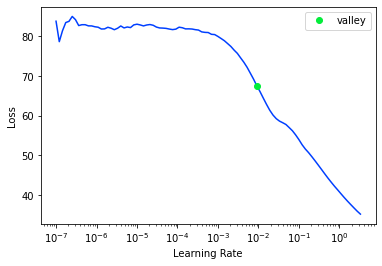

<Figure size 720x720 with 0 Axes>

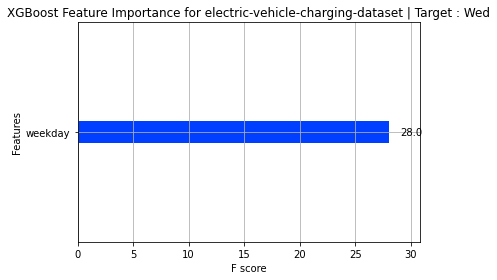

Target Variable: Tues
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:00, 38.71it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014516830444335938}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03398251533508301}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.4003705120946806e-11, 'Time taken': 0.030113697052001953}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02418231964111328}
{'Model': 'DummyRegressor', 'R-Squared': -0.0007191630832934504, 'Adjusted R-Squared': -0.04525378552417281, 'RMSE': 0.3963431475691235, 'Time taken': 0.022329330444335938}
{'Model': 'ElasticNet', 'R-Squared': -0.0007191249463831539, 'Adjusted R-Squared': -0.045253745690070346, 'RMSE': 0.39634317, 'Time taken': 0.024017810821533203}


 19%|█▉        | 8/42 [00:00<00:01, 27.51it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -296.598388671875 but the user-supplied value was -296.59857177734375.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.037656545639038086}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18537378311157227}
{'Model': 'GammaRegressor', 'R-Squared': 0.40051163321180205, 'Adjusted R-Squared': 0.37383283154845304, 'RMSE': 0.3067648714839712, 'Time taken': 0.023884296417236328}


 26%|██▌       | 11/42 [00:00<00:03,  8.86it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.5041264316462299, 'Adjusted R-Squared': 0.48205875975614076, 'RMSE': 0.27899776592713615, 'Time taken': 0.48693323135375977}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992939848, 'Adjusted R-Squared': 0.9999999992625652, 'RMSE': 1.0527428439119888e-05, 'Time taken': 0.19223999977111816}


 31%|███       | 13/42 [00:01<00:03,  8.00it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992939846, 'Adjusted R-Squared': 0.9999999992625651, 'RMSE': 1.0527428989192088e-05, 'Time taken': 0.1213231086730957}


 40%|████      | 17/42 [00:01<00:02,  9.32it/s]

{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.6379446160598794e-12, 'Time taken': 0.21987652778625488}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9789775441949355, 'Adjusted R-Squared': 0.9780419898790034, 'RMSE': 0.057445626465380276, 'Time taken': 0.04380989074707031}
{'Model': 'KernelRidge', 'R-Squared': -7.94046371616097, 'Adjusted R-Squared': -8.33833775588541, 'RMSE': 1.1846642, 'Time taken': 0.08825993537902832}
{'Model': 'Lars', 'R-Squared': 0.9999999999929968, 'Adjusted R-Squared': 0.9999999999926852, 'RMSE': 1.048487e-06, 'Time taken': 0.02418208122253418}


 50%|█████     | 21/42 [00:01<00:01, 12.37it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9999999999929968, 'Adjusted R-Squared': 0.9999999999926852, 'RMSE': 1.048487e-06, 'Time taken': 0.0764153003692627}
{'Model': 'Lasso', 'R-Squared': -0.0007191249463831539, 'Adjusted R-Squared': -0.045253745690070346, 'RMSE': 0.39634317, 'Time taken': 0.03908538818359375}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -296.598388671875 but the user-supplied value was -296.59857177734375.
{'Model': 'LassoLars', 'R-Squared': -0.0007191249463831539, 'Adjusted R-Squared': -0.045253745690070346, 'RMSE': 0.39634317, 'Time taken': 0.02328658103942871}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999929968, 'Adjusted R-Squared': 0.9999999999926852, 'RMSE': 1.048487e-06, 'Time taken': 0.05118107795715332}


 57%|█████▋    | 24/42 [00:02<00:01, 15.37it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999929968, 'Adjusted R-Squared': 0.9999999999926852, 'RMSE': 1.048487e-06, 'Time taken': 0.039366722106933594}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999989717, 'Adjusted R-Squared': 0.999999999998926, 'RMSE': 4.0175698e-07, 'Time taken': 0.023113727569580078}
{'Model': 'LinearSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 5.233293966757326e-12, 'Time taken': 0.02287888526916504}


 62%|██████▏   | 26/42 [00:02<00:02,  7.79it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9781479447550746, 'Adjusted R-Squared': 0.9771754710923424, 'RMSE': 0.058568135, 'Time taken': 0.5727484226226807}


 74%|███████▍  | 31/42 [00:04<00:02,  5.07it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9981980024450744, 'Adjusted R-Squared': 0.9981178088366092, 'RMSE': 0.0168186969229026, 'Time taken': 1.4314208030700684}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.14115641867250883, 'Adjusted R-Squared': 0.10293563102180903, 'RMSE': 0.3671743062618665, 'Time taken': 0.017534494400024414}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9711038644088117, 'Adjusted R-Squared': 0.9698179107306698, 'RMSE': 0.0673496168097992, 'Time taken': 0.038282155990600586}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9926572808545622, 'Adjusted R-Squared': 0.9923305106308123, 'RMSE': 0.033950306888967906, 'Time taken': 0.025340795516967773}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4878203884785238, 'Adjusted R-Squared': 0.4650270549814949, 'RMSE': 0.2835478698889902, 'Time taken': 0.0313107967376709}


 76%|███████▌  | 32/42 [00:41<00:58,  5.81s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.24223602467902605, 'Adjusted R-Squared': -0.29751877970400886, 'RMSE': 0.4415880432869419, 'Time taken': 37.42008638381958}
{'Model': 'RANSACRegressor', 'R-Squared': -0.24223602484472062, 'Adjusted R-Squared': -0.2975187798770771, 'RMSE': 0.44158804, 'Time taken': 0.19162821769714355}


 88%|████████▊ | 37/42 [00:42<00:11,  2.21s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2746603488922119}
{'Model': 'Ridge', 'R-Squared': 0.9999957014044237, 'Adjusted R-Squared': 0.9999955101056677, 'RMSE': 0.0008214451, 'Time taken': 0.017007827758789062}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999567495798, 'Adjusted R-Squared': 0.9999999548248228, 'RMSE': 8.239681252127936e-05, 'Time taken': 0.04510784149169922}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999333027178449, 'Adjusted R-Squared': 0.9999303345141888, 'RMSE': 0.003235707938967601, 'Time taken': 0.05627870559692383}


 93%|█████████▎| 39/42 [00:42<00:04,  1.53s/it]

{'Model': 'SVR', 'R-Squared': 0.9575952416365383, 'Adjusted R-Squared': 0.9557081188821435, 'RMSE': 0.08158729646277298, 'Time taken': 0.07671642303466797}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999989717, 'Adjusted R-Squared': 0.999999999998926, 'RMSE': 4.0175698e-07, 'Time taken': 0.025379180908203125}
{'Model': 'TweedieRegressor', 'R-Squared': 0.42101158441559283, 'Adjusted R-Squared': 0.3952450842456062, 'RMSE': 0.30147422200971397, 'Time taken': 0.04758262634277344}


100%|██████████| 42/42 [00:42<00:00,  1.02s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.999999990277136, 'Adjusted R-Squared': 0.9999999898444432, 'RMSE': 3.9067207e-05, 'Time taken': 0.4628932476043701}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992939846, 'Adjusted R-Squared': 0.9999999992625651, 'RMSE': 1.0527428989192088e-05, 'Time taken': 0.06367158889770508}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: Tues
Tues
Target Standard Deviation: 0.3877897102489956
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.03
DecisionTreeRegressor                        1.00       1.00  0.00        0.02
RandomForestRegressor                        1.00       1.00  0.00        0.27
ExtraTreeRegressor                           1.00       1.0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.976378321647644.
Better model found at epoch 1 with _rmse value: 0.7151666283607483.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       2       2.00
4       1       1.00
XGBoost RMSE:  3.9067207e-05


<Figure size 432x288 with 0 Axes>

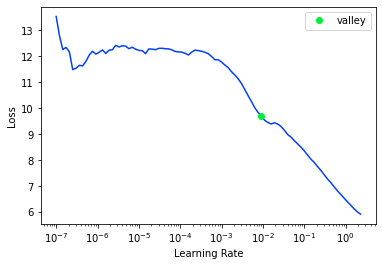

<Figure size 720x720 with 0 Axes>

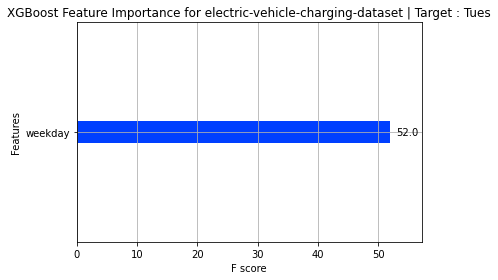

Target Variable: Mon
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 12%|█▏        | 5/42 [00:00<00:00, 42.77it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01569843292236328}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03424501419067383}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.5656506101853536e-11, 'Time taken': 0.022334575653076172}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023724794387817383}
{'Model': 'DummyRegressor', 'R-Squared': -0.0018503289473683626, 'Adjusted R-Squared': -0.04643529123036627, 'RMSE': 0.3926636800431127, 'Time taken': 0.02048945426940918}
{'Model': 'ElasticNet', 'R-Squared': -0.0018502985979922393, 'Adjusted R-Squared': -0.046435259530363426, 'RMSE': 0.39266366, 'Time taken': 0.04456138610839844}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - pleas

 24%|██▍       | 10/42 [00:00<00:01, 16.90it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2011728286743164}
{'Model': 'GammaRegressor', 'R-Squared': 0.4398359455209029, 'Adjusted R-Squared': 0.4149071786985348, 'RMSE': 0.29361411407548693, 'Time taken': 0.0242617130279541}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.3136844191922572, 'Adjusted R-Squared': 0.28314157920866667, 'RMSE': 0.3249984121289081, 'Time taken': 0.4799509048461914}


 31%|███       | 13/42 [00:01<00:03,  7.72it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992931866, 'Adjusted R-Squared': 0.9999999992617316, 'RMSE': 1.0429696634153527e-05, 'Time taken': 0.20485281944274902}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992931867, 'Adjusted R-Squared': 0.9999999992617317, 'RMSE': 1.0429696286141304e-05, 'Time taken': 0.11967182159423828}


 36%|███▌      | 15/42 [00:01<00:03,  7.62it/s]

{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.4868208435836596e-11, 'Time taken': 0.22494864463806152}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9844054580896686, 'Adjusted R-Squared': 0.9837114601512508, 'RMSE': 0.04898979485566356, 'Time taken': 0.04456162452697754}
{'Model': 'KernelRidge', 'R-Squared': -7.942953528639091, 'Adjusted R-Squared': -8.340938371536641, 'RMSE': 1.1731669, 'Time taken': 0.131272554397583}


 40%|████      | 17/42 [00:01<00:03,  8.13it/s]

{'Model': 'Lars', 'R-Squared': 0.9999999999966647, 'Adjusted R-Squared': 0.9999999999965162, 'RMSE': 7.1645303e-07, 'Time taken': 0.0560762882232666}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999966647, 'Adjusted R-Squared': 0.9999999999965162, 'RMSE': 7.1645303e-07, 'Time taken': 0.053922176361083984}
{'Model': 'Lasso', 'R-Squared': -0.0018502985979922393, 'Adjusted R-Squared': -0.046435259530363426, 'RMSE': 0.39266366, 'Time taken': 0.03753042221069336}


 55%|█████▍    | 23/42 [00:02<00:01, 11.93it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -309.5615234375 but the user-supplied value was -309.5618896484375.
{'Model': 'LassoLars', 'R-Squared': -0.0018502985979922393, 'Adjusted R-Squared': -0.046435259530363426, 'RMSE': 0.39266366, 'Time taken': 0.024515867233276367}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999966647, 'Adjusted R-Squared': 0.9999999999965162, 'RMSE': 7.1645303e-07, 'Time taken': 0.050020456314086914}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999966647, 'Adjusted R-Squared': 0.9999999999965162, 'RMSE': 7.1645303e-07, 'Time taken': 0.046453237533569336}
{'Model': 'LinearRegression', 'R-Squared': 0.999999999998209, 'Adjusted R-Squared': 0.9999999999981293, 'RMSE': 5.2500326e-07, 'Time taken': 0.022271156311035156}
{'Model': 'LinearSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE':

 62%|██████▏   | 26/42 [00:02<00:02,  7.90it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.4016794309132975, 'Adjusted R-Squared': 0.375052599304727, 'RMSE': 0.3034494, 'Time taken': 0.5992527008056641}


 74%|███████▍  | 31/42 [00:04<00:02,  4.97it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9809451277539952, 'Adjusted R-Squared': 0.9800971360571835, 'RMSE': 0.0541529762677928, 'Time taken': 1.578916072845459}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.24434790119576077, 'Adjusted R-Squared': 0.2107194046521167, 'RMSE': 0.34102031905147884, 'Time taken': 0.016197919845581055}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9690077781791198, 'Adjusted R-Squared': 0.9676285431766198, 'RMSE': 0.06906303597608106, 'Time taken': 0.04180026054382324}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9788557177411101, 'Adjusted R-Squared': 0.9779147418290653, 'RMSE': 0.0570447634725848, 'Time taken': 0.02691817283630371}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5308867282570129, 'Adjusted R-Squared': 0.510009959619236, 'RMSE': 0.2686941244635724, 'Time taken': 0.03311324119567871}


 76%|███████▌  | 32/42 [00:36<00:46,  4.64s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.23456790117685467, 'Adjusted R-Squared': -0.28950940463236896, 'RMSE': 0.4358898943438789, 'Time taken': 32.37386775016785}


 79%|███████▊  | 33/42 [00:37<00:35,  3.93s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.23456790123456783, 'Adjusted R-Squared': -0.2895094046926505, 'RMSE': 0.4358899, 'Time taken': 0.319305419921875}


 90%|█████████ | 38/42 [00:37<00:06,  1.64s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.2859923839569092}
{'Model': 'Ridge', 'R-Squared': 0.999996417281571, 'Adjusted R-Squared': 0.999996257841222, 'RMSE': 0.0007425499, 'Time taken': 0.015838623046875}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999641752565, 'Adjusted R-Squared': 0.9999999625809616, 'RMSE': 7.425246146392157e-05, 'Time taken': 0.0319218635559082}
{'Model': 'SGDRegressor', 'R-Squared': 0.9998885235516859, 'Adjusted R-Squared': 0.9998835625579128, 'RMSE': 0.00414200741133296, 'Time taken': 0.02683734893798828}
{'Model': 'SVR', 'R-Squared': 0.9422136404627505, 'Adjusted R-Squared': 0.9396419961901503, 'RMSE': 0.09430440463086921, 'Time taken': 0.09272646903991699}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.999999999998209, 'Adjusted R-Squared': 0.9999999999981293, 'RMSE': 5.2500326e-07, 'Time taken': 0.020011425018310547}
{'Model': 'TweedieRegressor', 'R-Squared': 0.46357082867178623, 'Adjust

100%|██████████| 42/42 [00:38<00:00,  1.10it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999902145024, 'Adjusted R-Squared': 0.9999999897790222, 'RMSE': 3.8807062e-05, 'Time taken': 0.4882979393005371}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992931867, 'Adjusted R-Squared': 0.9999999992617317, 'RMSE': 1.0429696286141304e-05, 'Time taken': 0.054978370666503906}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: Mon
Mon
Target Standard Deviation: 0.3783553017667388
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
BayesianRidge                                1.00       1.00  0.00        0.02
DecisionTreeRegressor                        1.00       1.00  0.00        0.02
RandomForestRegressor                        1.00       1.00  0.00        0.29
ExtraTreeRegressor                           1.00       1.0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.8375946283340454.
Better model found at epoch 1 with _rmse value: 0.7329019904136658.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       2       2.00
XGBoost RMSE:  3.8807062e-05


<Figure size 432x288 with 0 Axes>

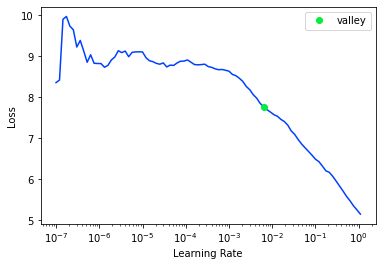

<Figure size 720x720 with 0 Axes>

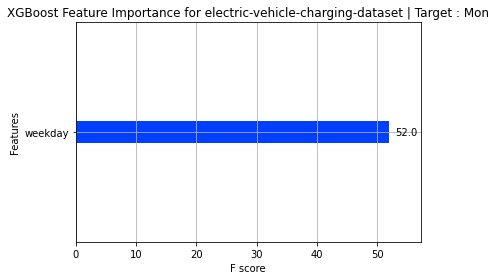

Target Variable: facilityType
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:02, 18.34it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8754788406698512, 'Adjusted R-Squared': 0.8699373231080383, 'RMSE': 0.3151822772374892, 'Time taken': 0.1361238956451416}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9917896650057973, 'Adjusted R-Squared': 0.9914242836055318, 'RMSE': 0.08093207028119323, 'Time taken': 0.05704641342163086}
{'Model': 'BayesianRidge', 'R-Squared': 0.3095002870845055, 'Adjusted R-Squared': 0.2787712422688946, 'RMSE': 0.7422017303073057, 'Time taken': 0.01785445213317871}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9968662843533578, 'Adjusted R-Squared': 0.9967268258036381, 'RMSE': 0.05, 'Time taken': 0.029867172241210938}
{'Model': 'DummyRegressor', 'R-Squared': -0.00033099871517650037, 'Adjusted R-Squared': -0.04484834682553762, 'RMSE': 0.8933303210459164, 'Time taken': 0.0382847785949707}
{'Model': 'ElasticNet', 'R-Squared': -0.0003309918602034667, 'Adjusted R-Squared': -0.04484833966550039, 'RMSE': 0.8933303, 'Time taken': 0.042946577072143555}


 17%|█▋        | 7/42 [00:00<00:01, 21.08it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -325.2311706542969 but the user-supplied value was -325.2305908203125.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.94359311836044, 'Adjusted R-Squared': 0.9410828644654858, 'RMSE': 0.21213203435596426, 'Time taken': 0.05254220962524414}


 24%|██▍       | 10/42 [00:00<00:02, 12.84it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9946614020243804, 'Adjusted R-Squared': 0.994423820439078, 'RMSE': 0.06526101439603894, 'Time taken': 0.2701094150543213}
{'Model': 'GammaRegressor', 'R-Squared': 0.2438109950954065, 'Adjusted R-Squared': 0.21015860482478332, 'RMSE': 0.7767037294797561, 'Time taken': 0.02429676055908203}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.39954338212943663, 'Adjusted R-Squared': 0.37282149075823356, 'RMSE': 0.692119410450024, 'Time taken': 0.48635292053222656}


 29%|██▊       | 12/42 [00:01<00:05,  5.85it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9625255247324417, 'Adjusted R-Squared': 0.9608578124823147, 'RMSE': 0.17290517489819765, 'Time taken': 0.3010590076446533}


 33%|███▎      | 14/42 [00:02<00:05,  5.16it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9726415368162672, 'Adjusted R-Squared': 0.9714240135855775, 'RMSE': 0.14773590615149182, 'Time taken': 0.4430680274963379}
{'Model': 'HuberRegressor', 'R-Squared': 0.1818010661690862, 'Adjusted R-Squared': 0.14538907173158488, 'RMSE': 0.8079224309529704, 'Time taken': 0.052794694900512695}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7644699319983705, 'Adjusted R-Squared': 0.7539882274014394, 'RMSE': 0.43347433603386487, 'Time taken': 0.042017221450805664}


 43%|████▎     | 18/42 [00:02<00:03,  7.44it/s]

{'Model': 'KernelRidge', 'R-Squared': -6.403079349186781, 'Adjusted R-Squared': -6.732535760014464, 'RMSE': 2.4302244, 'Time taken': 0.13622188568115234}
{'Model': 'Lars', 'R-Squared': 0.3096169675185422, 'Adjusted R-Squared': 0.278893115287692, 'RMSE': 0.74213904, 'Time taken': 0.05852961540222168}
{'Model': 'LarsCV', 'R-Squared': 0.30455291980444665, 'Adjusted R-Squared': 0.2736037041936499, 'RMSE': 0.7448559, 'Time taken': 0.07125711441040039}
{'Model': 'Lasso', 'R-Squared': -0.0003309918602034667, 'Adjusted R-Squared': -0.04484833966550039, 'RMSE': 0.8933303, 'Time taken': 0.04130864143371582}


 48%|████▊     | 20/42 [00:02<00:02,  9.04it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -325.2311706542969 but the user-supplied value was -325.2305908203125.
{'Model': 'LassoLars', 'R-Squared': -0.0003309918602034667, 'Adjusted R-Squared': -0.04484833966550039, 'RMSE': 0.8933303, 'Time taken': 0.045603275299072266}
{'Model': 'LassoLarsCV', 'R-Squared': 0.30455291980444665, 'Adjusted R-Squared': 0.2736037041936499, 'RMSE': 0.7448559, 'Time taken': 0.1460099220275879}


 57%|█████▋    | 24/42 [00:02<00:01, 10.31it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.30806846547030176, 'Adjusted R-Squared': 0.2772757008446346, 'RMSE': 0.7429709, 'Time taken': 0.09261322021484375}
{'Model': 'LinearRegression', 'R-Squared': 0.3096135701816103, 'Adjusted R-Squared': 0.27888956676037313, 'RMSE': 0.7421408, 'Time taken': 0.051030874252319336}
{'Model': 'LinearSVR', 'R-Squared': 0.12774678819713603, 'Adjusted R-Squared': 0.08892923688653742, 'RMSE': 0.8341833168111371, 'Time taken': 0.19092750549316406}


 62%|██████▏   | 26/42 [00:06<00:09,  1.64it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8102031486242371, 'Adjusted R-Squared': 0.8017566918876194, 'RMSE': 0.38912103, 'Time taken': 3.4266116619110107}


 74%|███████▍  | 31/42 [00:06<00:03,  3.47it/s]

{'Model': 'NuSVR', 'R-Squared': 0.6694344780079682, 'Adjusted R-Squared': 0.6547234469245532, 'RMSE': 0.5135337469993508, 'Time taken': 0.258805513381958}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0906649866053838, 'Adjusted R-Squared': 0.050197198051173175, 'RMSE': 0.851730438760345, 'Time taken': 0.018036842346191406}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.26473617575411723, 'Adjusted R-Squared': 0.23201501080076647, 'RMSE': 0.7658819082520223, 'Time taken': 0.03901267051696777}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.23070849685104977, 'Adjusted R-Squared': -0.28547824671091315, 'RMSE': 0.990872580645638, 'Time taken': 0.028360366821289062}
{'Model': 'PoissonRegressor', 'R-Squared': 0.2772155336668798, 'Adjusted R-Squared': 0.24504973280912323, 'RMSE': 0.7593545796457047, 'Time taken': 0.033182621002197266}


 76%|███████▌  | 32/42 [00:48<01:05,  6.59s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.5543229604591204, 'Adjusted R-Squared': -0.6234944011078245, 'RMSE': 1.113552872467345, 'Time taken': 41.73746848106384}


 79%|███████▊  | 33/42 [00:48<00:49,  5.45s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.6319580918841647, 'Adjusted R-Squared': -0.7045844991146117, 'RMSE': 1.1410239, 'Time taken': 0.1994185447692871}


 83%|████████▎ | 35/42 [00:49<00:25,  3.70s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9912036601798753, 'Adjusted R-Squared': 0.9908122000308122, 'RMSE': 0.08377051987423738, 'Time taken': 0.4894402027130127}
{'Model': 'Ridge', 'R-Squared': 0.3096157938897435, 'Adjusted R-Squared': 0.2788918894293394, 'RMSE': 0.7421397, 'Time taken': 0.016464948654174805}
{'Model': 'RidgeCV', 'R-Squared': 0.30959668624741166, 'Adjusted R-Squared': 0.2788719314469038, 'RMSE': 0.742149919914414, 'Time taken': 0.0306856632232666}
{'Model': 'SGDRegressor', 'R-Squared': 0.30812899366676705, 'Adjusted R-Squared': 0.2773389227042934, 'RMSE': 0.7429383501189685, 'Time taken': 0.026859521865844727}


 90%|█████████ | 38/42 [00:49<00:08,  2.18s/it]

{'Model': 'SVR', 'R-Squared': 0.6687948623687774, 'Adjusted R-Squared': 0.654055366715032, 'RMSE': 0.5140303285544041, 'Time taken': 0.19688987731933594}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3096135701816103, 'Adjusted R-Squared': 0.27888956676037313, 'RMSE': 0.7421408, 'Time taken': 0.02175283432006836}
{'Model': 'TweedieRegressor', 'R-Squared': 0.24403925987421438, 'Adjusted R-Squared': 0.2103970279837999, 'RMSE': 0.7765864919336729, 'Time taken': 0.02866983413696289}


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9943129524184556, 'Adjusted R-Squared': 0.9940598639135177, 'RMSE': 0.06735714, 'Time taken': 0.6915364265441895}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9734101529576208, 'Adjusted R-Squared': 0.9722268351573055, 'RMSE': 0.14564585549968137, 'Time taken': 0.13553500175476074}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: facilityType
facilityType
Target Standard Deviation: 0.8911360375947098
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
DecisionTreeRegressor                        1.00       1.00  0.05        0.03
ExtraTreesRegressor                          0.99       0.99  0.07        0.27
XGBRegressor                                 0.99       0.99  0.07        0.69
BaggingRegressor                             0.99       0.99  0.08        0.06
RandomForestRegressor                        0.9

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.893000066280365.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.00
1       1       1.00
2       1       1.00
3       3       3.00
4       3       2.67
XGBoost RMSE:  0.06735714


<Figure size 432x288 with 0 Axes>

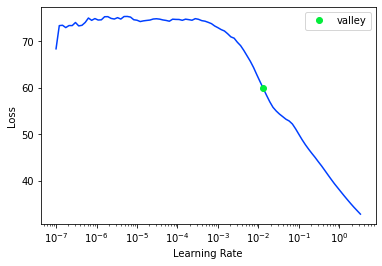

<Figure size 720x720 with 0 Axes>

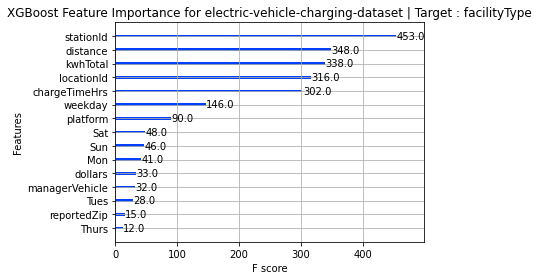

Target Variable: managerVehicle
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:01, 26.37it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6758617255728494, 'Adjusted R-Squared': 0.661436723831327, 'RMSE': 0.28309214487141426, 'Time taken': 0.026268959045410156}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9511615561566268, 'Adjusted R-Squared': 0.9489881175562672, 'RMSE': 0.10988630487917955, 'Time taken': 0.04688262939453125}
{'Model': 'BayesianRidge', 'R-Squared': 0.22196505349519635, 'Adjusted R-Squared': 0.18734046163503504, 'RMSE': 0.4385935223015691, 'Time taken': 0.04035377502441406}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.908996688490609, 'Adjusted R-Squared': 0.904946802899877, 'RMSE': 0.15, 'Time taken': 0.05856513977050781}
{'Model': 'DummyRegressor', 'R-Squared': -0.004109368285345916, 'Adjusted R-Squared': -0.04879486373259945, 'RMSE': 0.49825672662293274, 'Time taken': 0.04157114028930664}


 14%|█▍        | 6/42 [00:00<00:01, 24.94it/s]

{'Model': 'ElasticNet', 'R-Squared': -0.004109368255211354, 'Adjusted R-Squared': -0.048794863701123736, 'RMSE': 0.49825674, 'Time taken': 0.018109798431396484}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -306.88299560546875 but the user-supplied value was -306.88189697265625.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9191081675472079, 'Adjusted R-Squared': 0.915508269244335, 'RMSE': 0.1414213562373095, 'Time taken': 0.025322675704956055}


 21%|██▏       | 9/42 [00:00<00:02, 13.79it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.946255466518365, 'Adjusted R-Squared': 0.9438636940859362, 'RMSE': 0.11527358760791649, 'Time taken': 0.28458189964294434}
{'Model': 'GammaRegressor', 'R-Squared': 0.18422247674310488, 'Adjusted R-Squared': 0.1479182414149185, 'RMSE': 0.4491056601911703, 'Time taken': 0.025395870208740234}


 26%|██▌       | 11/42 [00:01<00:03,  7.82it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.09023014109625427, 'Adjusted R-Squared': 0.04974300077854843, 'RMSE': 0.47427303481468663, 'Time taken': 0.4833085536956787}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.92482373252222, 'Adjusted R-Squared': 0.9214781918229471, 'RMSE': 0.13633364325143427, 'Time taken': 0.28050947189331055}


 36%|███▌      | 15/42 [00:02<00:04,  6.01it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9283953595566585, 'Adjusted R-Squared': 0.9252087656102271, 'RMSE': 0.1330556267905022, 'Time taken': 0.5209119319915771}
{'Model': 'HuberRegressor', 'R-Squared': 0.1371904419768888, 'Adjusted R-Squared': 0.098793157981096, 'RMSE': 0.4618704046174387, 'Time taken': 0.07118463516235352}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7286079021208827, 'Adjusted R-Squared': 0.716530243314744, 'RMSE': 0.2590366769397724, 'Time taken': 0.04613780975341797}


 45%|████▌     | 19/42 [00:02<00:02,  8.50it/s]

{'Model': 'KernelRidge', 'R-Squared': -8.480753044751939, 'Adjusted R-Squared': -8.902671373968648, 'RMSE': 1.5310314, 'Time taken': 0.09917616844177246}
{'Model': 'Lars', 'R-Squared': 0.21516070204066517, 'Adjusted R-Squared': 0.18023329872833882, 'RMSE': 0.44050723, 'Time taken': 0.05912590026855469}
{'Model': 'LarsCV', 'R-Squared': 0.2246714895752514, 'Adjusted R-Squared': 0.19016734120556367, 'RMSE': 0.43783003, 'Time taken': 0.08791327476501465}
{'Model': 'Lasso', 'R-Squared': -0.004109368255211354, 'Adjusted R-Squared': -0.048794863701123736, 'RMSE': 0.49825674, 'Time taken': 0.039255619049072266}


 55%|█████▍    | 23/42 [00:02<00:01, 11.48it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -306.88299560546875 but the user-supplied value was -306.88189697265625.
{'Model': 'LassoLars', 'R-Squared': -0.004109368255211354, 'Adjusted R-Squared': -0.048794863701123736, 'RMSE': 0.49825674, 'Time taken': 0.05163216590881348}
{'Model': 'LassoLarsCV', 'R-Squared': 0.2246714895752514, 'Adjusted R-Squared': 0.19016734120556367, 'RMSE': 0.43783003, 'Time taken': 0.07021188735961914}
{'Model': 'LassoLarsIC', 'R-Squared': 0.24171642558259554, 'Adjusted R-Squared': 0.20797082148548596, 'RMSE': 0.4329906, 'Time taken': 0.0511622428894043}


 60%|█████▉    | 25/42 [00:02<00:01, 11.11it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.21668972790399632, 'Adjusted R-Squared': 0.1818303702452737, 'RMSE': 0.4400779, 'Time taken': 0.043886661529541016}
{'Model': 'LinearSVR', 'R-Squared': 7.661382442714082e-05, 'Adjusted R-Squared': -0.044422594460873155, 'RMSE': 0.4972170629722463, 'Time taken': 0.14069867134094238}
{'Model': 'MLPRegressor', 'R-Squared': 0.2280773882623277, 'Adjusted R-Squared': 0.19372481130018004, 'RMSE': 0.4368673, 'Time taken': 2.82800030708313}


 74%|███████▍  | 31/42 [00:06<00:03,  3.24it/s]

{'Model': 'NuSVR', 'R-Squared': 0.6968176857200729, 'Adjusted R-Squared': 0.6833252790636364, 'RMSE': 0.2737881157323081, 'Time taken': 0.3951530456542969}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.09977086423486525, 'Adjusted R-Squared': 0.0597083110725426, 'RMSE': 0.4717796385875836, 'Time taken': 0.018414020538330078}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.23966833842988178, 'Adjusted R-Squared': 0.20583158909299182, 'RMSE': 0.4335749661250369, 'Time taken': 0.03961539268493652}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.2183796571920158, 'Adjusted R-Squared': -0.2726007414126028, 'RMSE': 0.5488503943406331, 'Time taken': 0.026883840560913086}
{'Model': 'PoissonRegressor', 'R-Squared': 0.21093811547787022, 'Adjusted R-Squared': 0.17582279600960793, 'RMSE': 0.44169063756357607, 'Time taken': 0.03290843963623047}


 76%|███████▌  | 32/42 [00:48<01:02,  6.28s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.8099547544208912, 'Adjusted R-Squared': -0.8905024790940721, 'RMSE': 0.668954408620909, 'Time taken': 42.4940345287323}
{'Model': 'RANSACRegressor', 'R-Squared': -1.2346368715083802, 'Adjusted R-Squared': -1.3340840621252452, 'RMSE': 0.7433034, 'Time taken': 0.19308733940124512}


 83%|████████▎ | 35/42 [00:49<00:25,  3.62s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9432068555828004, 'Adjusted R-Squared': 0.940679411983082, 'RMSE': 0.11849789027657834, 'Time taken': 0.38506484031677246}
{'Model': 'Ridge', 'R-Squared': 0.2159058909224948, 'Adjusted R-Squared': 0.18101165046616607, 'RMSE': 0.44029805, 'Time taken': 0.015532732009887695}
{'Model': 'RidgeCV', 'R-Squared': 0.2159054466256315, 'Adjusted R-Squared': 0.18101118639692926, 'RMSE': 0.4402981691204882, 'Time taken': 0.030046701431274414}
{'Model': 'SGDRegressor', 'R-Squared': 0.2220648090545434, 'Adjusted R-Squared': 0.1874446565779132, 'RMSE': 0.4385654043199494, 'Time taken': 0.02640700340270996}


 90%|█████████ | 38/42 [00:49<00:08,  2.16s/it]

{'Model': 'SVR', 'R-Squared': 0.6999690280802549, 'Adjusted R-Squared': 0.6866168644084338, 'RMSE': 0.2723614925307586, 'Time taken': 0.17333698272705078}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.21668972790399632, 'Adjusted R-Squared': 0.1818303702452737, 'RMSE': 0.4400779, 'Time taken': 0.024990320205688477}
{'Model': 'TweedieRegressor', 'R-Squared': 0.18332628998919243, 'Adjusted R-Squared': 0.14698217200441832, 'RMSE': 0.4493522789410159, 'Time taken': 0.04585766792297363}


100%|██████████| 42/42 [00:50<00:00,  1.20s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9443611088070087, 'Adjusted R-Squared': 0.941885032497373, 'RMSE': 0.11728755, 'Time taken': 0.6047811508178711}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9285016125643174, 'Adjusted R-Squared': 0.9253197471548761, 'RMSE': 0.13295687055790326, 'Time taken': 0.1352078914642334}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: managerVehicle
managerVehicle
Target Standard Deviation: 0.4995744282636972
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BaggingRegressor                             0.95       0.95  0.11        0.05
ExtraTreesRegressor                          0.94       0.95  0.12        0.28
XGBRegressor                                 0.94       0.94  0.12        0.60
RandomForestRegressor                        0.94       0.94  0.12        0.39
LGBMRegressor                                0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.9324098825454712.
Better model found at epoch 1 with _rmse value: 0.7278117537498474.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.01
1       1       0.99
2       1       1.00
3       2       2.00
4       2       2.00
XGBoost RMSE:  0.11728755


<Figure size 432x288 with 0 Axes>

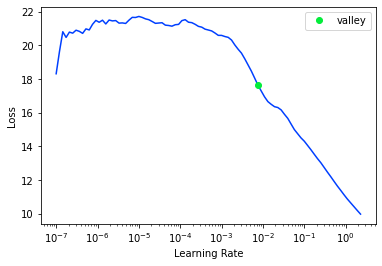

<Figure size 720x720 with 0 Axes>

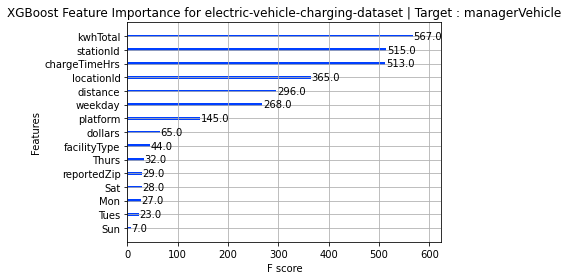

Target Variable: locationId
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:01, 22.26it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5622799370908962, 'Adjusted R-Squared': 0.5428002484274022, 'RMSE': 4.130683257825263, 'Time taken': 0.03850221633911133}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9080886449777205, 'Adjusted R-Squared': 0.9039983490735877, 'RMSE': 1.8928153634203204, 'Time taken': 0.057997703552246094}
{'Model': 'BayesianRidge', 'R-Squared': 0.33986143040103156, 'Adjusted R-Squared': 0.3104835359424388, 'RMSE': 5.072723862619227, 'Time taken': 0.03793621063232422}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8262592556309013, 'Adjusted R-Squared': 0.8185273376877739, 'RMSE': 2.602402735934621, 'Time taken': 0.057953596115112305}
{'Model': 'DummyRegressor', 'R-Squared': -9.428794433885557e-05, 'Adjusted R-Squared': -0.044601101805735954, 'RMSE': 6.243730386605831, 'Time taken': 0.04256153106689453}


 14%|█▍        | 6/42 [00:00<00:01, 23.41it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.2560869720390456, 'Adjusted R-Squared': 0.2229808948784796, 'RMSE': 5.384988, 'Time taken': 0.01858234405517578}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -319.71990966796875 but the user-supplied value was -319.7197265625.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7988737636244025, 'Adjusted R-Squared': 0.7899231195972163, 'RMSE': 2.8, 'Time taken': 0.02511119842529297}


 21%|██▏       | 9/42 [00:00<00:02, 12.37it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9201347276418221, 'Adjusted R-Squared': 0.9165805139504897, 'RMSE': 1.7644227809683257, 'Time taken': 0.33142542839050293}
{'Model': 'GammaRegressor', 'R-Squared': 0.25957136152655025, 'Adjusted R-Squared': 0.22662034881961668, 'RMSE': 5.372362042373477, 'Time taken': 0.025875568389892578}


 26%|██▌       | 11/42 [00:01<00:04,  7.46it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.9562796807961647, 'Adjusted R-Squared': -3.132344483344685, 'RMSE': 12.418443355369742, 'Time taken': 0.4846618175506592}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9020778314551112, 'Adjusted R-Squared': 0.8977200386141083, 'RMSE': 1.9537283534182752, 'Time taken': 0.28073930740356445}


 36%|███▌      | 15/42 [00:01<00:04,  6.43it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9524681948326665, 'Adjusted R-Squared': 0.9503529050739109, 'RMSE': 1.3611808234953426, 'Time taken': 0.4225335121154785}
{'Model': 'HuberRegressor', 'R-Squared': 0.21164285831303709, 'Adjusted R-Squared': 0.17655890174581634, 'RMSE': 5.543514285568003, 'Time taken': 0.06075716018676758}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6209745290873849, 'Adjusted R-Squared': 0.6041069034184989, 'RMSE': 3.8437741869157716, 'Time taken': 0.04254794120788574}
{'Model': 'KernelRidge', 'R-Squared': -2.6811620943857957, 'Adjusted R-Squared': -2.8449834441359485, 'RMSE': 11.978878, 'Time taken': 0.08972835540771484}


 48%|████▊     | 20/42 [00:02<00:02, 10.84it/s]

{'Model': 'Lars', 'R-Squared': 0.339533087951452, 'Adjusted R-Squared': 0.31014058139431766, 'RMSE': 5.073985, 'Time taken': 0.03279399871826172}
{'Model': 'LarsCV', 'R-Squared': 0.34056125942324234, 'Adjusted R-Squared': 0.3112145091881511, 'RMSE': 5.0700345, 'Time taken': 0.06557679176330566}
{'Model': 'Lasso', 'R-Squared': 0.26347977372066267, 'Adjusted R-Squared': 0.23070269558781265, 'RMSE': 5.3581643, 'Time taken': 0.02335643768310547}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -319.71990966796875 but the user-supplied value was -319.7197265625.
{'Model': 'LassoLars', 'R-Squared': -9.427527155492221e-05, 'Adjusted R-Squared': -0.04460108856898004, 'RMSE': 6.2437305, 'Time taken': 0.022965669631958008}


 60%|█████▉    | 25/42 [00:02<00:01, 13.31it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.34056125942324234, 'Adjusted R-Squared': 0.3112145091881511, 'RMSE': 5.0700345, 'Time taken': 0.1139063835144043}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3404767553523207, 'Adjusted R-Squared': 0.3111262444648586, 'RMSE': 5.070359, 'Time taken': 0.03862190246582031}
{'Model': 'LinearRegression', 'R-Squared': 0.33828179712329964, 'Adjusted R-Squared': 0.30883360484868216, 'RMSE': 5.078789, 'Time taken': 0.02226734161376953}
{'Model': 'LinearSVR', 'R-Squared': -0.059309190424624125, 'Adjusted R-Squared': -0.10645122245922778, 'RMSE': 6.425915909554421, 'Time taken': 0.09938573837280273}
{'Model': 'MLPRegressor', 'R-Squared': 0.6475529284013566, 'Adjusted R-Squared': 0.631868111078904, 'RMSE': 3.7065566, 'Time taken': 2.895258903503418}


 74%|███████▍  | 31/42 [00:05<00:03,  3.61it/s]

{'Model': 'NuSVR', 'R-Squared': 0.5235023631486291, 'Adjusted R-Squared': 0.5022969709327304, 'RMSE': 4.3097695013973345, 'Time taken': 0.2190401554107666}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.26784062983507306, 'Adjusted R-Squared': 0.23525762121516802, 'RMSE': 5.342277955396731, 'Time taken': 0.01796865463256836}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.32657734433309327, 'Adjusted R-Squared': 0.29660827326938277, 'RMSE': 5.123509307138249, 'Time taken': 0.03863692283630371}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.6169450688222955, 'Adjusted R-Squared': -0.6889033572253818, 'RMSE': 7.939100525205662, 'Time taken': 0.025874853134155273}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3699490874714437, 'Adjusted R-Squared': 0.34191017251598443, 'RMSE': 4.955773971641683, 'Time taken': 0.03308582305908203}


 76%|███████▌  | 32/42 [00:49<01:00,  6.02s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.3554856518712841, 'Adjusted R-Squared': -0.41580831177131494, 'RMSE': 7.2689407743483, 'Time taken': 43.77655005455017}


 79%|███████▊  | 33/42 [00:49<00:46,  5.12s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.020766892103504464, 'Adjusted R-Squared': -0.06619369096674932, 'RMSE': 6.307931, 'Time taken': 0.3402409553527832}


 83%|████████▎ | 35/42 [00:50<00:25,  3.61s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8973935970218438, 'Adjusted R-Squared': 0.8928273434861668, 'RMSE': 1.9999120605666638, 'Time taken': 0.5202093124389648}
{'Model': 'Ridge', 'R-Squared': 0.33956752269737844, 'Adjusted R-Squared': 0.31017654857658117, 'RMSE': 5.073853, 'Time taken': 0.016077518463134766}
{'Model': 'RidgeCV', 'R-Squared': 0.3397870106606353, 'Adjusted R-Squared': 0.31040580432877884, 'RMSE': 5.0730097875533335, 'Time taken': 0.04381823539733887}
{'Model': 'SGDRegressor', 'R-Squared': 0.33625116385647347, 'Adjusted R-Squared': 0.30671260308568826, 'RMSE': 5.086576192180995, 'Time taken': 0.03621864318847656}


 90%|█████████ | 38/42 [00:50<00:08,  2.20s/it]

{'Model': 'SVR', 'R-Squared': 0.4900537802026117, 'Adjusted R-Squared': 0.46735983848387985, 'RMSE': 4.4584700776890065, 'Time taken': 0.2315659523010254}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.33828179712329964, 'Adjusted R-Squared': 0.30883360484868216, 'RMSE': 5.078789, 'Time taken': 0.01425790786743164}
{'Model': 'TweedieRegressor', 'R-Squared': 0.26018493378885177, 'Adjusted R-Squared': 0.22726122665380077, 'RMSE': 5.3701356188274705, 'Time taken': 0.04430794715881348}


100%|██████████| 42/42 [00:51<00:00,  1.23s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.937354047731937, 'Adjusted R-Squared': 0.9345661388613687, 'RMSE': 1.5626805, 'Time taken': 0.722628116607666}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9504454600973002, 'Adjusted R-Squared': 0.9482401533477036, 'RMSE': 1.3898418733659292, 'Time taken': 0.13694524765014648}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: locationId
locationId
Target Standard Deviation: 6.398620182068553
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor                0.95       0.95  1.36        0.42
LGBMRegressor                                0.95       0.95  1.39        0.14
XGBRegressor                                 0.93       0.94  1.56        0.72
ExtraTreesRegressor                          0.92       0.92  1.76        0.33
BaggingRegressor                             0.90       0

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 8.04679012298584.
Better model found at epoch 1 with _rmse value: 7.626911163330078.
Better model found at epoch 2 with _rmse value: 6.905155658721924.
Better model found at epoch 3 with _rmse value: 6.874429702758789.
Better model found at epoch 4 with _rmse value: 5.796716213226318.
Better model found at epoch 5 with _rmse value: 5.736717224121094.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.23
1       6       6.10
2      17      17.07
3      18      18.43
4      21      20.96
XGBoost RMSE:  1.5473213


<Figure size 432x288 with 0 Axes>

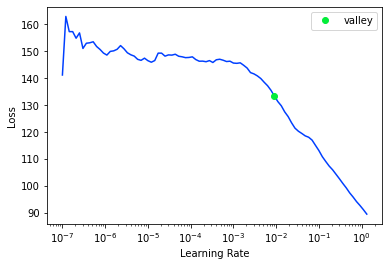

<Figure size 720x720 with 0 Axes>

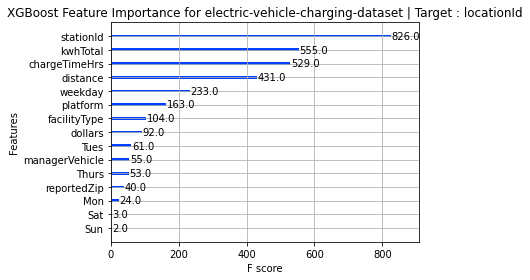

Target Variable: stationId
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:02, 17.79it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.13693477284795785, 'Adjusted R-Squared': 0.09852611090663665, 'RMSE': 23.83128324641303, 'Time taken': 0.042345523834228516}
{'Model': 'BaggingRegressor', 'R-Squared': 0.17026578540097348, 'Adjusted R-Squared': 0.13334044077222107, 'RMSE': 23.3665781619817, 'Time taken': 0.07296991348266602}
{'Model': 'BayesianRidge', 'R-Squared': 0.10726787825288231, 'Adjusted R-Squared': 0.06753896184005259, 'RMSE': 24.237409453633415, 'Time taken': 0.03506970405578613}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.605255863487602, 'Adjusted R-Squared': -0.6766939516532804, 'RMSE': 32.501076905235, 'Time taken': 0.07366585731506348}


 19%|█▉        | 8/42 [00:00<00:01, 23.01it/s]

{'Model': 'DummyRegressor', 'R-Squared': -6.347523279037759e-05, 'Adjusted R-Squared': -0.0445689178478621, 'RMSE': 25.653073288411758, 'Time taken': 0.03328251838684082}
{'Model': 'ElasticNet', 'R-Squared': 0.0771260732995217, 'Adjusted R-Squared': 0.03605576766101881, 'RMSE': 24.643183, 'Time taken': 0.02094435691833496}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -311.06341552734375 but the user-supplied value was -311.0628356933594.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.2820300456629887, 'Adjusted R-Squared': -0.33908373879458753, 'RMSE': 29.045223359444147, 'Time taken': 0.05980253219604492}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.0780635959086885, 'Adjusted R-Squared': 0.037035012480541196, 'RMSE': 24.630662927538108, 'Time taken': 0.45726823806762695}
{'Model': 'GammaRegressor', 'R-Square

 26%|██▌       | 11/42 [00:01<00:04,  6.39it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -156548.40006379358, 'Adjusted R-Squared': -163515.2581818158, 'RMSE': 10149.655991162392, 'Time taken': 0.4874701499938965}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.24185676316958604, 'Adjusted R-Squared': 0.2081174044624734, 'RMSE': 22.33578658867215, 'Time taken': 0.2650742530822754}


 36%|███▌      | 15/42 [00:02<00:04,  6.12it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.19666859038019013, 'Adjusted R-Squared': 0.1609182396903034, 'RMSE': 22.991801048546943, 'Time taken': 0.41333651542663574}
{'Model': 'HuberRegressor', 'R-Squared': 0.09221036109252656, 'Adjusted R-Squared': 0.05181134574847679, 'RMSE': 24.44095827751546, 'Time taken': 0.05834174156188965}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1450505016120638, 'Adjusted R-Squared': 0.10700301084610864, 'RMSE': 23.718971309902965, 'Time taken': 0.04320955276489258}


 45%|████▌     | 19/42 [00:02<00:02,  8.63it/s]

{'Model': 'KernelRidge', 'R-Squared': -2.3691038533182947, 'Adjusted R-Squared': -2.5190377944345537, 'RMSE': 47.085026, 'Time taken': 0.13701891899108887}
{'Model': 'Lars', 'R-Squared': 0.10825716415352049, 'Adjusted R-Squared': 0.06857227355302276, 'RMSE': 24.223976, 'Time taken': 0.04265308380126953}
{'Model': 'LarsCV', 'R-Squared': 0.10838831706000429, 'Adjusted R-Squared': 0.06870926310717729, 'RMSE': 24.222195, 'Time taken': 0.0711207389831543}
{'Model': 'Lasso', 'R-Squared': 0.08918645222272803, 'Adjusted R-Squared': 0.048652865017980385, 'RMSE': 24.481632, 'Time taken': 0.024845361709594727}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -311.06341552734375 but the user-supplied value was -311.0628356933594.
{'Model': 'LassoLars', 'R-Squared': -6.347823619679005e-05, 'Adjusted R-Squared': -0.04456892098492804, 'R

 52%|█████▏    | 22/42 [00:02<00:01, 11.46it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.10838831706000429, 'Adjusted R-Squared': 0.06870926310717729, 'RMSE': 24.222195, 'Time taken': 0.0755624771118164}
{'Model': 'LassoLarsIC', 'R-Squared': 0.10825728893473052, 'Adjusted R-Squared': 0.06857240388732333, 'RMSE': 24.223974, 'Time taken': 0.03949427604675293}
{'Model': 'LinearRegression', 'R-Squared': 0.1082572529759751, 'Adjusted R-Squared': 0.06857236632830921, 'RMSE': 24.223974, 'Time taken': 0.022099733352661133}
{'Model': 'LinearSVR', 'R-Squared': -0.0007693518268458988, 'Adjusted R-Squared': -0.045306207798197606, 'RMSE': 25.66212506876963, 'Time taken': 0.028783559799194336}


 62%|██████▏   | 26/42 [00:05<00:05,  2.75it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.17476862708133412, 'Adjusted R-Squared': 0.13804367069490142, 'RMSE': 23.30309, 'Time taken': 2.865978956222534}


 74%|███████▍  | 31/42 [00:05<00:02,  4.61it/s]

{'Model': 'NuSVR', 'R-Squared': 0.07146656539407192, 'Adjusted R-Squared': 0.030144396838310827, 'RMSE': 24.71862972849809, 'Time taken': 0.22792553901672363}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.024309727344999144, 'Adjusted R-Squared': -0.019111043951165696, 'RMSE': 25.338541116517746, 'Time taken': 0.01670551300048828}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.09591152593590635, 'Adjusted R-Squared': 0.05567722211630022, 'RMSE': 24.391083061880988, 'Time taken': 0.03876066207885742}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.05857068080221639, 'Adjusted R-Squared': -0.10567984722535151, 'RMSE': 26.392805024892695, 'Time taken': 0.025957584381103516}
{'Model': 'PoissonRegressor', 'R-Squared': 0.11188515794521658, 'Adjusted R-Squared': 0.0723617225658153, 'RMSE': 24.174649318697103, 'Time taken': 0.03774571418762207}


 79%|███████▊  | 33/42 [00:53<00:50,  5.64s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04664104707062622, 'Adjusted R-Squared': -0.09321931356329793, 'RMSE': 26.243665902245432, 'Time taken': 47.781595945358276}
{'Model': 'RANSACRegressor', 'R-Squared': -0.6526698728218792, 'Adjusted R-Squared': -0.7262180085233763, 'RMSE': 32.97757, 'Time taken': 0.1705327033996582}


 83%|████████▎ | 35/42 [00:54<00:27,  3.96s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.20182314056444128, 'Adjusted R-Squared': 0.16630218085134063, 'RMSE': 22.9179192663732, 'Time taken': 0.6710491180419922}
{'Model': 'Ridge', 'R-Squared': 0.10824711967777845, 'Adjusted R-Squared': 0.06856178207181574, 'RMSE': 24.224112, 'Time taken': 0.012283086776733398}
{'Model': 'RidgeCV', 'R-Squared': 0.10814832607607894, 'Adjusted R-Squared': 0.06845859189621861, 'RMSE': 24.22545455809279, 'Time taken': 0.027030467987060547}
{'Model': 'SGDRegressor', 'R-Squared': 0.10801114444310145, 'Adjusted R-Squared': 0.06831530532145946, 'RMSE': 24.227317625533633, 'Time taken': 0.03596854209899902}


 90%|█████████ | 38/42 [00:54<00:09,  2.40s/it]

{'Model': 'SVR', 'R-Squared': 0.06364576136084543, 'Adjusted R-Squared': 0.02197554655229672, 'RMSE': 24.822510852597635, 'Time taken': 0.24597811698913574}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.1082572529759751, 'Adjusted R-Squared': 0.06857236632830921, 'RMSE': 24.223974, 'Time taken': 0.01715826988220215}
{'Model': 'TweedieRegressor', 'R-Squared': 0.06925315274419741, 'Adjusted R-Squared': 0.02783248153124296, 'RMSE': 24.748073989166365, 'Time taken': 0.02954411506652832}


100%|██████████| 42/42 [00:55<00:00,  1.33s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.11693907713961549, 'Adjusted R-Squared': 0.07764055439451989, 'RMSE': 24.105766, 'Time taken': 0.6550321578979492}
{'Model': 'LGBMRegressor', 'R-Squared': 0.18709565498038494, 'Adjusted R-Squared': 0.1509192836051666, 'RMSE': 23.12838676928755, 'Time taken': 0.137786865234375}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: stationId
stationId
Target Standard Deviation: 25.915207521055567
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.21       0.24    22.34   
RandomForestRegressor                        0.17       0.20    22.92   
HistGradientBoostingRegressor                0.16       0.20    22.99   
LGBMRegressor                                0.15       0.19    23.13   
MLPRegressor                                 0.14       0.17    23.30   
BaggingRegressor   

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 40.826725006103516.
Better model found at epoch 1 with _rmse value: 29.16040802001953.
Better model found at epoch 2 with _rmse value: 28.18324089050293.
Better model found at epoch 3 with _rmse value: 23.90876007080078.
No improvement since epoch 3: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      55      24.08
1      23      27.63
2      71      66.30
3      38      45.56
4      20      60.94
XGBoost RMSE:  24.102184


<Figure size 432x288 with 0 Axes>

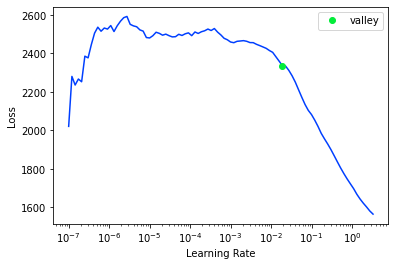

<Figure size 720x720 with 0 Axes>

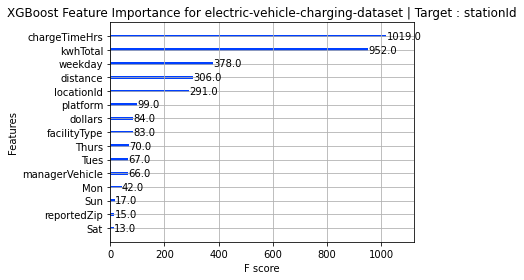

Target Variable: distance
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:01, 23.85it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8126916427684854, 'Adjusted R-Squared': 0.8043559305356693, 'RMSE': 6.194091068048751, 'Time taken': 0.03488945960998535}
{'Model': 'BaggingRegressor', 'R-Squared': 0.903675864281038, 'Adjusted R-Squared': 0.8993891880841208, 'RMSE': 4.4418774183896605, 'Time taken': 0.050100088119506836}
{'Model': 'BayesianRidge', 'R-Squared': 0.6274679746743546, 'Adjusted R-Squared': 0.6108893243326374, 'RMSE': 8.735360156553657, 'Time taken': 0.04049539566040039}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.837830593935228, 'Adjusted R-Squared': 0.8306136308381046, 'RMSE': 5.7634625009624205, 'Time taken': 0.056304931640625}
{'Model': 'DummyRegressor', 'R-Squared': -0.006372566848653394, 'Adjusted R-Squared': -0.05115878055657763, 'RMSE': 14.357486069991504, 'Time taken': 0.04117298126220703}


 14%|█▍        | 6/42 [00:00<00:01, 23.71it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.5239173958358354, 'Adjusted R-Squared': 0.5027304736609904, 'RMSE': 9.87507, 'Time taken': 0.026101350784301758}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -310.7073059082031 but the user-supplied value was -310.7073669433594.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8435547943901371, 'Adjusted R-Squared': 0.8365925731980752, 'RMSE': 5.660830327787612, 'Time taken': 0.024283170700073242}


 21%|██▏       | 9/42 [00:00<00:02, 13.27it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9396076798997813, 'Adjusted R-Squared': 0.9369200635602428, 'RMSE': 3.517141701723148, 'Time taken': 0.29613161087036133}
{'Model': 'GammaRegressor', 'R-Squared': 0.42820560897369586, 'Adjusted R-Squared': 0.40275926172906984, 'RMSE': 10.822284688647727, 'Time taken': 0.028453588485717773}


 26%|██▌       | 11/42 [00:01<00:04,  7.48it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -17.774079461780875, 'Adjusted R-Squared': -18.609575144634995, 'RMSE': 62.01237071523267, 'Time taken': 0.5058383941650391}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.888286671388937, 'Adjusted R-Squared': 0.8833151358224761, 'RMSE': 4.783563075511193, 'Time taken': 0.27147650718688965}


 31%|███       | 13/42 [00:01<00:05,  5.05it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9234825868337708, 'Adjusted R-Squared': 0.9200773616405094, 'RMSE': 3.9589420841187333, 'Time taken': 0.4150512218475342}
{'Model': 'HuberRegressor', 'R-Squared': 0.5993879769231851, 'Adjusted R-Squared': 0.5815596931736934, 'RMSE': 9.058598234388832, 'Time taken': 0.05278277397155762}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8569120757928079, 'Adjusted R-Squared': 0.8505442885898701, 'RMSE': 5.413778717310119, 'Time taken': 0.0434117317199707}


 43%|████▎     | 18/42 [00:02<00:03,  7.78it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.41710978599053306, 'Adjusted R-Squared': -0.4801748811785933, 'RMSE': 17.037298, 'Time taken': 0.13836979866027832}
{'Model': 'Lars', 'R-Squared': 0.6271258693542137, 'Adjusted R-Squared': 0.6105319944301866, 'RMSE': 8.73937, 'Time taken': 0.060500383377075195}
{'Model': 'LarsCV', 'R-Squared': 0.6272615788716411, 'Adjusted R-Squared': 0.6106737433764, 'RMSE': 8.73778, 'Time taken': 0.07345962524414062}
{'Model': 'Lasso', 'R-Squared': 0.5889655944545094, 'Adjusted R-Squared': 0.5706734874014379, 'RMSE': 9.175676, 'Time taken': 0.038459062576293945}


 55%|█████▍    | 23/42 [00:02<00:01, 11.37it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -310.7073059082031 but the user-supplied value was -310.7073669433594.
{'Model': 'LassoLars', 'R-Squared': -0.006372621925640809, 'Adjusted R-Squared': -0.05115883808463528, 'RMSE': 14.357487, 'Time taken': 0.04835224151611328}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6272615788716411, 'Adjusted R-Squared': 0.6106737433764, 'RMSE': 8.73778, 'Time taken': 0.07065415382385254}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6271259503102853, 'Adjusted R-Squared': 0.6105320789890153, 'RMSE': 8.739369, 'Time taken': 0.03872847557067871}
{'Model': 'LinearRegression', 'R-Squared': 0.6257914033939798, 'Adjusted R-Squared': 0.6091381412413559, 'RMSE': 8.754994, 'Time taken': 0.022855281829833984}
{'Model': 'LinearSVR', 'R-Squared': 0.5439681643094982, 'Adjusted R-Squared': 0.523673553820654,

 62%|██████▏   | 26/42 [00:05<00:06,  2.35it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8562277482064089, 'Adjusted R-Squared': 0.8498295066344428, 'RMSE': 5.426709, 'Time taken': 3.0297443866729736}


 74%|███████▍  | 31/42 [00:05<00:02,  4.20it/s]

{'Model': 'NuSVR', 'R-Squared': 0.6674657649855369, 'Adjusted R-Squared': 0.6526671210189248, 'RMSE': 8.253101579400681, 'Time taken': 0.2196943759918213}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5254792388628047, 'Adjusted R-Squared': 0.5043618227912541, 'RMSE': 9.858858148757902, 'Time taken': 0.016744375228881836}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.6133278155906959, 'Adjusted R-Squared': 0.5961198911536327, 'RMSE': 8.899599740670645, 'Time taken': 0.04104304313659668}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.48173903855242994, 'Adjusted R-Squared': 0.4586750690639255, 'RMSE': 10.303226731530508, 'Time taken': 0.025919198989868164}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6768713376220687, 'Adjusted R-Squared': 0.6624912662597001, 'RMSE': 8.135546846098462, 'Time taken': 0.03922247886657715}


 76%|███████▌  | 32/42 [00:57<01:16,  7.67s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.29474335348984915, 'Adjusted R-Squared': -0.35236282210065384, 'RMSE': 16.285115905524535, 'Time taken': 51.94577980041504}


 79%|███████▊  | 33/42 [00:58<00:57,  6.42s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.30348919517162276, 'Adjusted R-Squared': 0.2724926410300458, 'RMSE': 11.944362, 'Time taken': 0.3025059700012207}


 83%|████████▎ | 35/42 [00:58<00:30,  4.39s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9102947377388603, 'Adjusted R-Squared': 0.9063026187377101, 'RMSE': 4.286550740397225, 'Time taken': 0.42522549629211426}
{'Model': 'Ridge', 'R-Squared': 0.627178184291072, 'Adjusted R-Squared': 0.6105866375186851, 'RMSE': 8.738757, 'Time taken': 0.01576375961303711}
{'Model': 'RidgeCV', 'R-Squared': 0.6271781171000066, 'Adjusted R-Squared': 0.6105865673374415, 'RMSE': 8.738757875142197, 'Time taken': 0.03043985366821289}
{'Model': 'SGDRegressor', 'R-Squared': 0.6332732267000024, 'Adjusted R-Squared': 0.6169529252704213, 'RMSE': 8.667030350775429, 'Time taken': 0.03422832489013672}


 90%|█████████ | 38/42 [00:58<00:10,  2.62s/it]

{'Model': 'SVR', 'R-Squared': 0.7214190280780336, 'Adjusted R-Squared': 0.7090214455579461, 'RMSE': 7.553960914567762, 'Time taken': 0.23348522186279297}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6257914033939798, 'Adjusted R-Squared': 0.6091381412413559, 'RMSE': 8.754994, 'Time taken': 0.01855015754699707}
{'Model': 'TweedieRegressor', 'R-Squared': 0.4811172464002703, 'Adjusted R-Squared': 0.45802560553326666, 'RMSE': 10.309405612042587, 'Time taken': 0.028862953186035156}


100%|██████████| 42/42 [00:59<00:00,  1.42s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9236074057421584, 'Adjusted R-Squared': 0.9202077353170712, 'RMSE': 3.9557118, 'Time taken': 0.7033190727233887}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9142032389315492, 'Adjusted R-Squared': 0.9103850584651522, 'RMSE': 4.192127233618873, 'Time taken': 0.13723015785217285}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: distance
distance
Target Standard Deviation: 13.912314464171661
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.94       0.94  3.52        0.30
XGBRegressor                                 0.92       0.92  3.96        0.70
HistGradientBoostingRegressor                0.92       0.92  3.96        0.42
LGBMRegressor                                0.91       0.91  4.19        0.14
RandomForestRegressor                        0.91       0.9

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 16.69146156311035.
Better model found at epoch 1 with _rmse value: 16.225093841552734.
Better model found at epoch 2 with _rmse value: 12.884510040283203.
Better model found at epoch 3 with _rmse value: 11.907413482666016.
Better model found at epoch 4 with _rmse value: 10.603765487670898.
Better model found at epoch 5 with _rmse value: 10.376057624816895.
Better model found at epoch 6 with _rmse value: 9.955968856811523.
No improvement since epoch 6: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       0.99
1      35      31.19
2      21      19.48
3       1       1.29
4       1       0.96
XGBoost RMSE:  3.9563825


<Figure size 432x288 with 0 Axes>

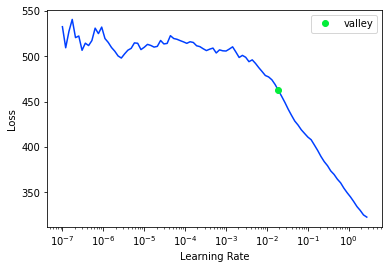

<Figure size 720x720 with 0 Axes>

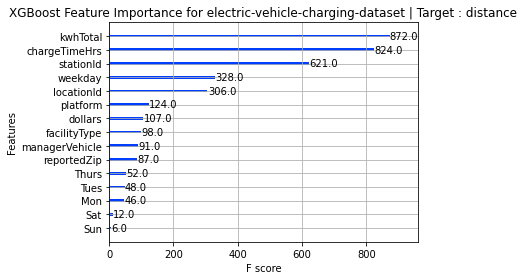

Target Variable: platform
CATS=====================
['dollars', 'weekday', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 71%|███████▏  | 30/42 [00:00<00:00, 142.01it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

100%|██████████| 42/42 [00:00<00:00, 138.28it/s]

PoissonRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
QuantileRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RANSACRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RandomForestRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Ridge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RidgeCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Tweed

LEARNING RATE: 0.1


Could not fit model
XGBoost failed
Target Variable: weekday
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Tabular Object size: 2000


 12%|█▏        | 5/42 [00:00<00:00, 45.22it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015722274780273438}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02805352210998535}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024681806564331055}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.021806716918945312}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01990532875061035}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.06902265548706055}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -305.3377685546875 but the user-supplied val

 24%|██▍       | 10/42 [00:00<00:01, 22.90it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.15962743759155273}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01817631721496582}


 31%|███       | 13/42 [00:01<00:02,  9.86it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 0.1891271480350133, 'Time taken': 0.49045872688293457}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.1054072380065918}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04894280433654785}


 36%|███▌      | 15/42 [00:01<00:02, 10.00it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 3.0351800255040337e-12, 'Time taken': 0.14593839645385742}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04293012619018555}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 1.0001062, 'Time taken': 0.14201664924621582}


 50%|█████     | 21/42 [00:01<00:01, 14.40it/s]

{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03669333457946777}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0401151180267334}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -305.3377685546875 but the user-supplied value was -305.33740234375.
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03706979751586914}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries


 55%|█████▍    | 23/42 [00:01<00:01, 15.29it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04633831977844238}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023016691207885742}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 8.63022809540097e-12, 'Time taken': 0.021793603897094727}


 67%|██████▋   | 28/42 [00:02<00:01, 10.41it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 0.046543572, 'Time taken': 0.5092189311981201}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10465312004089355}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.020969152450561523}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 0.028506161516626393, 'Time taken': 0.025130271911621094}


 74%|███████▍  | 31/42 [00:02<00:00, 13.28it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04930377006530762}


 76%|███████▌  | 32/42 [00:30<00:40,  4.04s/it]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 1.0125233984581428e-13, 'Time taken': 28.529149770736694}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05001521110534668}


 90%|█████████ | 38/42 [00:31<00:06,  1.63s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.21613526344299316}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01844954490661621}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.043024539947509766}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 0.0005250867116906139, 'Time taken': 0.027280807495117188}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02205348014831543}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024119138717651367}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023575782775878906}


100%|██████████| 42/42 [00:31<00:00,  1.31it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.04450261780104703, 'RMSE': 5.9604645e-08, 'Time taken': 0.5155739784240723}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.042137861251831055}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: weekday
weekday
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lasso                                        1.00       1.00  0.00        0.04
TweedieRegressor                             1.00       1.00  0.00        0.02
TransformedTargetRegressor                   1.00       1.00  0.00        0.02
SVR                                          1.00       1.00  0.00        0.02
RidgeCV                                      1.00

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.6179420351982117.
Better model found at epoch 1 with _rmse value: 0.5456867218017578.
No improvement since epoch 1: early stopping


Could not show results


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 310, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: chargeTimeHrs
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal']
17
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:02, 15.81it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.48308855880309953, 'Adjusted R-Squared': 0.46008464649852543, 'RMSE': 0.8713787281972109, 'Time taken': 0.06559944152832031}
{'Model': 'BaggingRegressor', 'R-Squared': 0.46162487557777077, 'Adjusted R-Squared': 0.43766577318201716, 'RMSE': 0.8892858336065785, 'Time taken': 0.07395100593566895}
{'Model': 'BayesianRidge', 'R-Squared': 0.35245990917854186, 'Adjusted R-Squared': 0.3236426800058593, 'RMSE': 0.9752864992367744, 'Time taken': 0.0360107421875}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.30962875290721603, 'Adjusted R-Squared': 0.27890542515701366, 'RMSE': 1.007024946293994, 'Time taken': 0.07972073554992676}


 17%|█▋        | 7/42 [00:00<00:01, 19.45it/s]

{'Model': 'DummyRegressor', 'R-Squared': -9.638493713604035e-06, 'Adjusted R-Squared': -0.04451268523296248, 'RMSE': 1.2119954, 'Time taken': 0.026435136795043945}
{'Model': 'ElasticNet', 'R-Squared': 0.07838383230453738, 'Adjusted R-Squared': 0.03736950023432051, 'RMSE': 1.1635202, 'Time taken': 0.01683783531188965}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -282.2147216796875 but the user-supplied value was -282.2141418457031.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -3.749233876824743, 'Adjusted R-Squared': -3.9605872168928595, 'RMSE': 2.6412569933739465, 'Time taken': 0.04809713363647461}


 21%|██▏       | 9/42 [00:01<00:04,  6.98it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.45623651380478614, 'Adjusted R-Squared': 0.4320376152044756, 'RMSE': 0.8937249908578409, 'Time taken': 0.5766847133636475}
{'Model': 'GammaRegressor', 'R-Squared': 0.2710109595648047, 'Adjusted R-Squared': 0.2385690389171652, 'RMSE': 1.0348070552911748, 'Time taken': 0.029103755950927734}


 26%|██▌       | 11/42 [00:01<00:05,  5.52it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -221366.02222529196, 'Adjusted R-Squared': -231217.43420914002, 'RMSE': 570.2369340604873, 'Time taken': 0.48506712913513184}


 29%|██▊       | 12/42 [00:01<00:05,  5.22it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5617234113967593, 'Adjusted R-Squared': 0.5422189558830026, 'RMSE': 0.8023669245646625, 'Time taken': 0.2285773754119873}


 38%|███▊      | 16/42 [00:02<00:04,  6.47it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.47888870997286725, 'Adjusted R-Squared': 0.4556978934009792, 'RMSE': 0.8749114952297166, 'Time taken': 0.41894078254699707}
{'Model': 'HuberRegressor', 'R-Squared': 0.3610446072836757, 'Adjusted R-Squared': 0.33260941964970325, 'RMSE': 0.9688000474389785, 'Time taken': 0.04419112205505371}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.328939307111595, 'Adjusted R-Squared': 0.2990753495746765, 'RMSE': 0.9928412, 'Time taken': 0.04407763481140137}
{'Model': 'KernelRidge', 'R-Squared': -5.249555890915531, 'Adjusted R-Squared': -5.527677488155226, 'RMSE': 3.0298662, 'Time taken': 0.09180331230163574}


 43%|████▎     | 18/42 [00:02<00:02,  8.02it/s]

{'Model': 'Lars', 'R-Squared': 0.3507260758898024, 'Adjusted R-Squared': 0.3218316865969403, 'RMSE': 0.97659135, 'Time taken': 0.03575539588928223}
{'Model': 'LarsCV', 'R-Squared': 0.3545370424286758, 'Adjusted R-Squared': 0.3258122511231457, 'RMSE': 0.973721, 'Time taken': 0.07554078102111816}
{'Model': 'Lasso', 'R-Squared': -9.638493713604035e-06, 'Adjusted R-Squared': -0.04451268523296248, 'RMSE': 1.2119954, 'Time taken': 0.036675453186035156}


 52%|█████▏    | 22/42 [00:02<00:01, 11.22it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -282.2147216796875 but the user-supplied value was -282.2141418457031.
{'Model': 'LassoLars', 'R-Squared': -9.638493713604035e-06, 'Adjusted R-Squared': -0.04451268523296248, 'RMSE': 1.2119954, 'Time taken': 0.03155708312988281}
{'Model': 'LassoLarsCV', 'R-Squared': 0.3545370424286758, 'Adjusted R-Squared': 0.3258122511231457, 'RMSE': 0.973721, 'Time taken': 0.06699824333190918}
{'Model': 'LassoLarsIC', 'R-Squared': 0.35620514324800334, 'Adjusted R-Squared': 0.3275545867956894, 'RMSE': 0.972462, 'Time taken': 0.035549163818359375}
{'Model': 'LinearRegression', 'R-Squared': 0.3515042678378376, 'Adjusted R-Squared': 0.3226445101238148, 'RMSE': 0.9760059, 'Time taken': 0.022746562957763672}


 60%|█████▉    | 25/42 [00:02<00:01, 13.85it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.3557625487572992, 'Adjusted R-Squared': 0.32709229569152465, 'RMSE': 0.9727961998899226, 'Time taken': 0.07474493980407715}
{'Model': 'MLPRegressor', 'R-Squared': 0.26113434756018894, 'Adjusted R-Squared': 0.22825289182333874, 'RMSE': 1.0417935, 'Time taken': 2.8793013095855713}


 74%|███████▍  | 31/42 [00:06<00:03,  3.53it/s]

{'Model': 'NuSVR', 'R-Squared': 0.42801693778085403, 'Adjusted R-Squared': 0.4025621941742429, 'RMSE': 0.9166223990960752, 'Time taken': 0.24427270889282227}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2120535336234025, 'Adjusted R-Squared': 0.17698785318255927, 'RMSE': 1.075838885616184, 'Time taken': 0.016961336135864258}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.34953713542791376, 'Adjusted R-Squared': 0.32058983517208794, 'RMSE': 0.9774850754073565, 'Time taken': 0.0390009880065918}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.26665476145071576, 'Adjusted R-Squared': -0.32302421418543337, 'RMSE': 1.3640428437537835, 'Time taken': 0.031034231185913086}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3064923246668799, 'Adjusted R-Squared': 0.2756294176494375, 'RMSE': 1.0093098635140083, 'Time taken': 0.031775474548339844}


 79%|███████▊  | 33/42 [00:50<00:46,  5.22s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0011285567638859018, 'Adjusted R-Squared': -0.045681398295262854, 'RMSE': 1.2126732739054964, 'Time taken': 43.872519731521606}
{'Model': 'RANSACRegressor', 'R-Squared': 0.0001972446847098297, 'Adjusted R-Squared': -0.044296595211520184, 'RMSE': 1.2118701, 'Time taken': 0.18131041526794434}


 83%|████████▎ | 35/42 [00:50<00:25,  3.68s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5053739954101566, 'Adjusted R-Squared': 0.4833618433734359, 'RMSE': 0.8523880531409985, 'Time taken': 0.6926877498626709}
{'Model': 'Ridge', 'R-Squared': 0.35077038924305337, 'Adjusted R-Squared': 0.32187797201041446, 'RMSE': 0.97655797, 'Time taken': 0.016517162322998047}
{'Model': 'RidgeCV', 'R-Squared': 0.3511544482358435, 'Adjusted R-Squared': 0.3222791226337738, 'RMSE': 0.9762691081862929, 'Time taken': 0.04183816909790039}
{'Model': 'SGDRegressor', 'R-Squared': 0.3244628467925512, 'Adjusted R-Squared': 0.2943996750529527, 'RMSE': 0.996147160006027, 'Time taken': 0.029846906661987305}


 90%|█████████ | 38/42 [00:51<00:08,  2.24s/it]

{'Model': 'SVR', 'R-Squared': 0.40150091503055174, 'Adjusted R-Squared': 0.37486613899788, 'RMSE': 0.9376281269706318, 'Time taken': 0.27387499809265137}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3515042678378376, 'Adjusted R-Squared': 0.3226445101238148, 'RMSE': 0.9760059, 'Time taken': 0.01877117156982422}
{'Model': 'TweedieRegressor', 'R-Squared': 0.286204997160333, 'Adjusted R-Squared': 0.254439250960662, 'RMSE': 1.0239662277434736, 'Time taken': 0.050699710845947266}


100%|██████████| 42/42 [00:52<00:00,  1.25s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.47612261552191826, 'Adjusted R-Squared': 0.45280870050587807, 'RMSE': 0.8772304, 'Time taken': 1.1471905708312988}
{'Model': 'LGBMRegressor', 'R-Squared': 0.4825966622282426, 'Adjusted R-Squared': 0.4595708592384, 'RMSE': 0.8717932346820092, 'Time taken': 0.13054847717285156}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: chargeTimeHrs
chargeTimeHrs
Target Standard Deviation: 1.7752642631530762
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
GradientBoostingRegressor                    0.54       0.56   0.80   
RandomForestRegressor                        0.48       0.51   0.85   
AdaBoostRegressor                            0.46       0.48   0.87   
LGBMRegressor                                0.46       0.48   0.87   
HistGradientBoostingRegressor                0.46       0.48   0.87   
XGBRegressor              

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.234581232070923.
Better model found at epoch 1 with _rmse value: 1.626577377319336.
No improvement since epoch 1: early stopping


<Figure size 432x288 with 0 Axes>

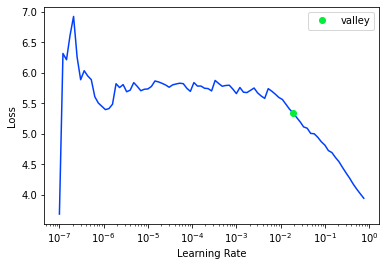

<Figure size 720x720 with 0 Axes>

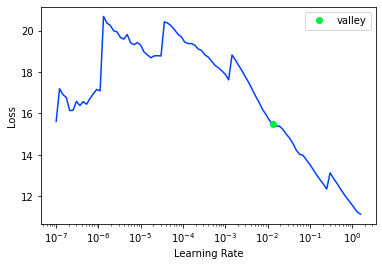

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    0.01      -0.14
1    2.04       2.04
2    3.17       1.71
3    2.22       2.77
4    1.96       1.84
XGBoost RMSE:  0.87738615


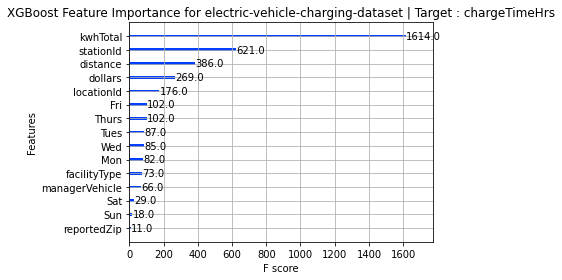

Target Variable: dollars
CATS=====================
['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
CONTS=====================
['kwhTotal', 'chargeTimeHrs']
18
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['kwhTotal', 'chargeTimeHrs']
Categorical variables that made the cut : ['dollars', 'weekday', 'platform', 'distance', 'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip']
Tabular Object size: 2000


 17%|█▋        | 7/42 [00:00<00:01, 31.01it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6070595915923223, 'Adjusted R-Squared': 0.589572714778368, 'RMSE': 1.836976814174105, 'Time taken': 0.05094146728515625}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5959139590871908, 'Adjusted R-Squared': 0.5779310724497098, 'RMSE': 1.86284728305892, 'Time taken': 0.04209470748901367}
{'Model': 'BayesianRidge', 'R-Squared': 0.20140506348976306, 'Adjusted R-Squared': 0.1658654982523966, 'RMSE': 2.6188076735203754, 'Time taken': 0.033388614654541016}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5321838310854674, 'Adjusted R-Squared': 0.5113647869191139, 'RMSE': 2.0043702252827447, 'Time taken': 0.042311668395996094}
{'Model': 'DummyRegressor', 'R-Squared': -0.0014411838339967176, 'Adjusted R-Squared': -0.0460079380883891, 'RMSE': 2.9326015008009527, 'Time taken': 0.02083110809326172}
{'Model': 'ElasticNet', 'R-Squared': 0.10848892309448888, 'Adjusted R-Squared': 0.0688143463735631, 'RMSE': 2.7669652, 'Time taken': 0.02398967742919922}
E

 26%|██▌       | 11/42 [00:01<00:03,  8.53it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -17.321117936525834, 'Adjusted R-Squared': -18.136455645742952, 'RMSE': 12.543430096562428, 'Time taken': 0.4910004138946533}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.4483011006452646, 'Adjusted R-Squared': 0.4237490553860225, 'RMSE': 2.1766639647419423, 'Time taken': 0.286456823348999}


 31%|███       | 13/42 [00:01<00:05,  5.76it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7839029531438498, 'Adjusted R-Squared': 0.7742860688596757, 'RMSE': 1.3622748682131205, 'Time taken': 0.3813052177429199}
{'Model': 'HuberRegressor', 'R-Squared': -0.03985024515944402, 'Adjusted R-Squared': -0.08612630319009984, 'RMSE': 2.9883105493111226, 'Time taken': 0.160919189453125}


 40%|████      | 17/42 [00:02<00:03,  7.74it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1287498799165091, 'Adjusted R-Squared': 0.08997696881331718, 'RMSE': 2.7353427573157996, 'Time taken': 0.04236888885498047}
{'Model': 'KernelRidge', 'R-Squared': -0.11071281055732585, 'Adjusted R-Squared': -0.16014243825228536, 'RMSE': 3.0884545, 'Time taken': 0.09030938148498535}
{'Model': 'Lars', 'R-Squared': 0.20665827471876275, 'Adjusted R-Squared': 0.1713524911329486, 'RMSE': 2.6101801, 'Time taken': 0.027840375900268555}


 45%|████▌     | 19/42 [00:02<00:02,  9.07it/s]

{'Model': 'LarsCV', 'R-Squared': -0.0014411044813256169, 'Adjusted R-Squared': -0.046007855204316384, 'RMSE': 2.9326012, 'Time taken': 0.08076691627502441}
{'Model': 'Lasso', 'R-Squared': 0.06590442320184087, 'Adjusted R-Squared': 0.02433472475794385, 'RMSE': 2.8322785, 'Time taken': 0.03788590431213379}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (8,9) we computed -299.27752685546875 but the user-supplied value was -299.2774658203125.
{'Model': 'LassoLars', 'R-Squared': -0.0014411044813256169, 'Adjusted R-Squared': -0.046007855204316384, 'RMSE': 2.9326012, 'Time taken': 0.05051159858703613}


 60%|█████▉    | 25/42 [00:02<00:01, 12.48it/s]

{'Model': 'LassoLarsCV', 'R-Squared': -0.0014411044813256169, 'Adjusted R-Squared': -0.046007855204316384, 'RMSE': 2.9326012, 'Time taken': 0.0675344467163086}
{'Model': 'LassoLarsIC', 'R-Squared': 0.2051995203863919, 'Adjusted R-Squared': 0.1698288184140586, 'RMSE': 2.6125786, 'Time taken': 0.05101370811462402}
{'Model': 'LinearRegression', 'R-Squared': 0.20665799862216805, 'Adjusted R-Squared': 0.17135220274933272, 'RMSE': 2.6101806, 'Time taken': 0.029744625091552734}
{'Model': 'LinearSVR', 'R-Squared': -0.039850252246586004, 'Adjusted R-Squared': -0.0861263105926382, 'RMSE': 2.988310559494599, 'Time taken': 0.1038198471069336}
{'Model': 'MLPRegressor', 'R-Squared': 0.3259314978241281, 'Adjusted R-Squared': 0.2959336849000711, 'RMSE': 2.4059818, 'Time taken': 2.8951351642608643}


 74%|███████▍  | 31/42 [00:05<00:03,  3.51it/s]

{'Model': 'NuSVR', 'R-Squared': 0.12094554833308391, 'Adjusted R-Squared': 0.08182532404424214, 'RMSE': 2.7475665312534017, 'Time taken': 0.3247184753417969}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.20877629712735024, 'Adjusted R-Squared': 0.1735647710832795, 'RMSE': 2.6066935253184575, 'Time taken': 0.02121734619140625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.20877629712735024, 'Adjusted R-Squared': 0.1735647710832795, 'RMSE': 2.6066935253184575, 'Time taken': 0.04635930061340332}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.4446849437540392, 'Adjusted R-Squared': -0.5089772056488524, 'RMSE': 3.522304535790076, 'Time taken': 0.03018021583557129}
{'Model': 'PoissonRegressor', 'R-Squared': 0.04331984448837478, 'Adjusted R-Squared': 0.0007450731697946633, 'RMSE': 2.8663136469163395, 'Time taken': 0.043509721755981445}


 79%|███████▊  | 33/42 [00:41<00:37,  4.16s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.03985025224284011, 'Adjusted R-Squared': -0.08612631058872555, 'RMSE': 2.988310559489217, 'Time taken': 35.908018827438354}
{'Model': 'RANSACRegressor', 'R-Squared': -0.039850252248108564, 'Adjusted R-Squared': -0.08612631059422848, 'RMSE': 2.9883106, 'Time taken': 0.1382761001586914}


 83%|████████▎ | 35/42 [00:42<00:20,  2.93s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.595641187618446, 'Adjusted R-Squared': 0.5776461619365444, 'RMSE': 1.8634759188140853, 'Time taken': 0.351609468460083}
{'Model': 'Ridge', 'R-Squared': 0.20657896591775182, 'Adjusted R-Squared': 0.17126965288267804, 'RMSE': 2.6103106, 'Time taken': 0.016158103942871094}
{'Model': 'RidgeCV', 'R-Squared': 0.20586549746006544, 'Adjusted R-Squared': 0.17052443321090616, 'RMSE': 2.6114839512334527, 'Time taken': 0.04633903503417969}
{'Model': 'SGDRegressor', 'R-Squared': 0.17724876378610654, 'Adjusted R-Squared': 0.14063417997554073, 'RMSE': 2.658120105935164, 'Time taken': 0.028975963592529297}


 90%|█████████ | 38/42 [00:42<00:07,  1.80s/it]

{'Model': 'SVR', 'R-Squared': 0.1531702873145594, 'Adjusted R-Squared': 0.11548414826834874, 'RMSE': 2.696735625873847, 'Time taken': 0.17918634414672852}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.20665799862216805, 'Adjusted R-Squared': 0.17135220274933272, 'RMSE': 2.6101806, 'Time taken': 0.02624654769897461}
{'Model': 'TweedieRegressor', 'R-Squared': 0.12272559105056735, 'Adjusted R-Squared': 0.08368458332245132, 'RMSE': 2.744783276930205, 'Time taken': 0.05192422866821289}


100%|██████████| 42/42 [00:43<00:00,  1.03s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.6103501250893302, 'Adjusted R-Squared': 0.5930096856299549, 'RMSE': 1.8292692, 'Time taken': 0.6074602603912354}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7208116997618255, 'Adjusted R-Squared': 0.7083870895418021, 'RMSE': 1.548420584039714, 'Time taken': 0.12100601196289062}
Project: electric-vehicle-charging-dataset
electric-vehicle-charging-dataset
Target: dollars
dollars
Target Standard Deviation: 3.235194884006217
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor                0.77       0.78  1.36        0.38
ExtraTreesRegressor                          0.72       0.73  1.52        0.28
LGBMRegressor                                0.71       0.72  1.55        0.12
XGBRegressor                                 0.59       0.61  1.83        0.61
AdaBoostRegressor                            0.59       0.61  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.0651447772979736.
Better model found at epoch 1 with _rmse value: 3.0262293815612793.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  1.8292692


<Figure size 432x288 with 0 Axes>

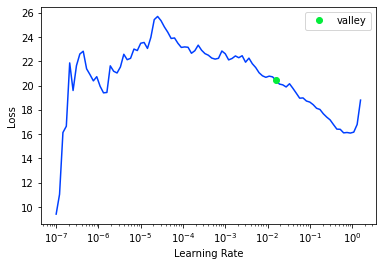

<Figure size 720x720 with 0 Axes>

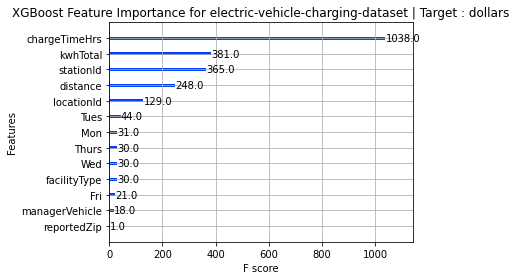

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

     feature  importance
0    dollars       65.00
1    weekday      268.00
2   platform      145.00
3   distance      296.00
4  stationId      515.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

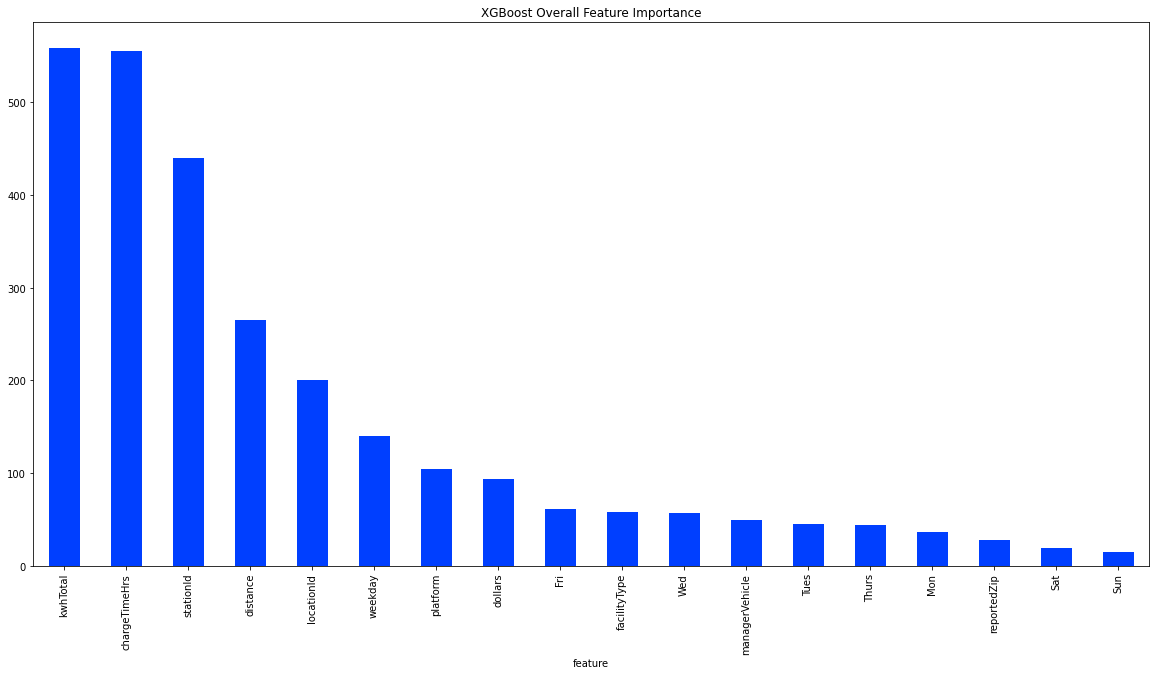

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

kwhTotal          0
dollars           0
chargeTimeHrs     0
weekday           0
platform          0
distance          0
stationId         0
locationId        0
managerVehicle    0
facilityType      0
Mon               0
Tues              0
Wed               0
Thurs             0
Fri               0
Sat               0
Sun               0
reportedZip       0
dtype: int64

# **To Be Continued...**